# Supplementary Figure 16: LogLike Surfaces

In [1]:
import sys
import os
import logging
import time
import argparse
import warnings

In [2]:
#Select the correct working directory
os.chdir('/u/project/klohmuel/amzurita/Synonimous_Selection_Simulations/FigurePlots_Revision')

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import ast
import matplotlib.cm as cm

## Load all the replicate data

In [4]:
#Dic with the shape {'condition_dadioutput':[rep_number, rep_number, ...]}
plotting_replicates={'Zero':[4, 1], 'E5':[5, 8], 'E4':[3, 9], 'E5_Partial':[12, 7], 'E4_Partial':[2, 3], 'E3_Partial':[1, 6]}

#All the loglike surfaces and other parameters. Data identified as "condition_dadioutput_Rep{rep_number}"
inferred_dem_params={}
likelihood_mle={}
loglike_surfaces={}
loglike_surfaces_rescaled={}
x_values={}
y_values={}
map_dataid_condition={}

all_dataids=[]

for condition in plotting_replicates.keys():
    for rep in plotting_replicates[condition]:
        dataid=f"{condition}_Rep{rep}"
        print(f"Processing {dataid}...")
        map_dataid_condition[dataid]=condition
        all_dataids.append(dataid)

        #Get the originally inferred demographic parameters
        input_file_demography=f"/u/project/klohmuel/amzurita/Synonimous_Selection_Simulations/Dadi_Fits/DadiFits_OutputFiles_BugFix/{condition}_TwoEpoch_Replicate{rep}_two_epoch_demography.txt"
      
        with open(input_file_demography, 'r') as file:
            for line in file:
                if 'Maximum multinomial log composite likelihood: ' in line:
                    parsed_params=line.strip().strip('.').split(': ')[1]
                    print(parsed_params)
                    likelihood_model=float(parsed_params)
                    likelihood_mle[dataid]=likelihood_model
                elif 'Best fit parameters: ' in line:
                    parsed_params=line.strip().strip('.').split(': ')[1]
                    parsed_params=parsed_params.strip('[').strip(']')
                    demog_params=[float(x.strip(',')) for x in parsed_params.split()]
                    print(demog_params)
                    inferred_dem_params[dataid]=demog_params


        #Load the loglike surface
        df=pd.read_csv(f"/u/project/klohmuel/amzurita/Synonimous_Selection_Simulations/Dadi_Fits/DadiFits_OutputFiles_BugFix/likelihood_surface_{condition}_Replicate{rep}.csv", index_col=0)
        input_nu, input_tau = demog_params

        like_max = abs(likelihood_model)+10
        like_min = abs(likelihood_model)-10    

        #Prepare the data
        Z = df.pivot_table(index='X', columns='Y', values='Z').T.values
        X_unique = np.sort(df.X.unique())
        Y_unique = np.sort(df.Y.unique())
        X, Y = np.meshgrid(X_unique, Y_unique)

        #Store the x and y values for plotting
        x_values[dataid] = X_unique
        y_values[dataid] = Y_unique

        #Plotting with a log scale color gradient
        Z = np.abs(Z)  # Ensure all values are positive, for log scaling.

        #Rescale with respect to the maximum likelihood
        Z_rescaled = Z - abs(likelihood_model)

        loglike_surfaces[dataid] = Z
        loglike_surfaces_rescaled[dataid] = Z_rescaled

Processing Zero_Rep4...
[1.05112303, 0.29287213]
-385.93556972426063
Processing Zero_Rep1...
[1.04342915, 0.52922326]
-383.76912957863703
Processing E5_Rep5...
[1.12483276, 0.98631176]
-390.40811237734727
Processing E5_Rep8...
[1.3411726, 2.3415574]
-380.8796316579489
Processing E4_Rep3...
[3.96785231, 3.50016724]
-360.2281707132488
Processing E4_Rep9...
[3.59238498, 2.95034013]
-360.2741376185646
Processing E5_Partial_Rep12...
[3.92827324, 20.0]
-377.73212639779365
Processing E5_Partial_Rep7...
[1.12328338, 1.84138738]
-389.7599840424779
Processing E4_Partial_Rep2...
[1.22651524, 0.95140762]
-381.6523916894837
Processing E4_Partial_Rep3...
[1.18471739, 0.90600848]
-386.42023822306925
Processing E3_Partial_Rep1...
[1.31072675, 0.14239728]
-369.76919285034353
Processing E3_Partial_Rep6...
[1.29046065, 0.21162172]
-376.2300129101715


## Plotting the grid of MLE surfaces

In [5]:
color_scheme= 'jet'
like_max_rescaled = 10
like_min_rescaled = -1

title_conditions={'SLiM_True_DFE':'True model', 'Zero':'s=0', 'E5':'s=1e-05', 'E4':'s=1e-4',
                  'E3': 's=1e-3', 'E5_Partial':'22% at s=1e-05' ,'E3_Partial':'22% at s=1e-03', 
                  'E4_Partial':'22% at s=1e-04'}

color_conditions={'SLiM_True_DFE':'#99b3ff', 'Zero':'#3366ff', 'E5':'#267326', 'E4':'#9bc238',
                  'E3': '#7D2FB9', 'E5_Partial':'#cc0000' ,'E3_Partial':'#E6BE00', 
                  'E4_Partial':'#ff6600'}

In [6]:
all_dataids

['Zero_Rep4',
 'Zero_Rep1',
 'E5_Rep5',
 'E5_Rep8',
 'E4_Rep3',
 'E4_Rep9',
 'E5_Partial_Rep12',
 'E5_Partial_Rep7',
 'E4_Partial_Rep2',
 'E4_Partial_Rep3',
 'E3_Partial_Rep1',
 'E3_Partial_Rep6']

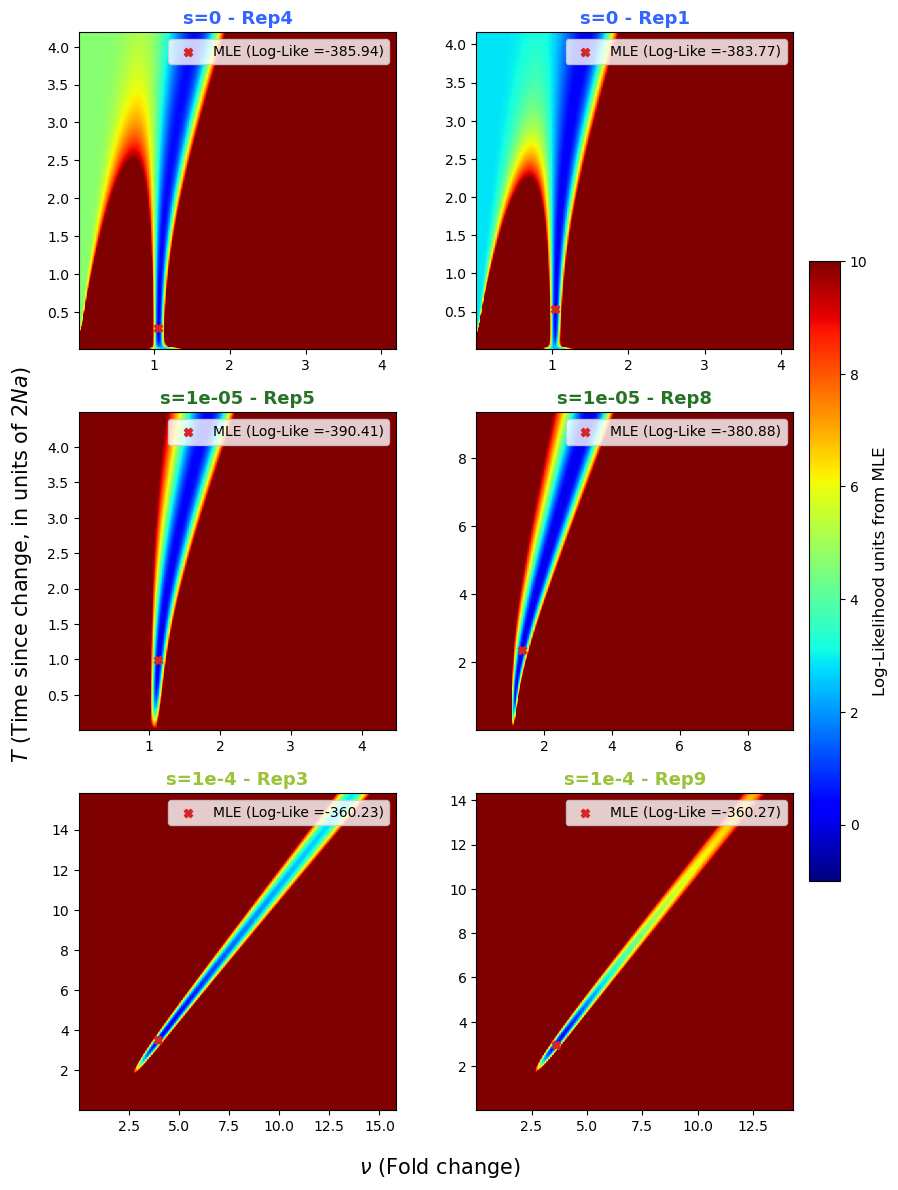

In [7]:
conditions_to_plot = ['Zero_Rep4', 'Zero_Rep1', 'E5_Rep5', 'E5_Rep8', 'E4_Rep3', 'E4_Rep9']

fig, axes = plt.subplots(3, 2, figsize=(10, 14))
axes = axes.flatten()

# Shared colormap and normalization
norm = Normalize(vmin=like_min_rescaled, vmax=like_max_rescaled)
cmap = cm.get_cmap(color_scheme)

for ax, dataid in zip(axes, conditions_to_plot):
    #Access the data
    Z_rescaled=loglike_surfaces_rescaled[dataid]
    X_unique = x_values[dataid]
    Y_unique = y_values[dataid]
    input_nu, input_tau = inferred_dem_params[dataid]
    likelihood_model = likelihood_mle[dataid]


    ax.imshow(Z_rescaled ,cmap=cmap, norm=norm, origin='lower', aspect='equal',\
            extent = [min(X_unique), max(X_unique), min(Y_unique), max(Y_unique)])

    #Add the true value
    ax.scatter(input_nu, input_tau, color='C3', marker='X', s=35, label=f"MLE (Log-Like ={likelihood_model:.2f})")
    ax.legend()

    #Create the title 
    condition = map_dataid_condition[dataid]
    rep_id = dataid.split('_')[-1]
    ax.set_title(f"{title_conditions[condition]} - {rep_id}", fontsize=13, color=color_conditions[condition], weight='bold')


#Set y and x labels grid-wide
fig.supxlabel(r"$\it{\nu}$ (Fold change)", fontsize=15, y=0.06)
fig.supylabel(r"$\it{T}$ (Time since change, in units of $\it{2Na}$)", fontsize=15, x=0.07)

#Make a grid-wide colorbar

#Set the title

# Create a ScalarMappable for the colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cb = fig.colorbar(mappable, ax=axes, orientation='vertical', fraction=0.04, pad=0.02)
cb.set_label('Log-Likelihood units from MLE', fontsize=12)
#plt.tight_layout()

plt.savefig('SuppFig16A_LogLikeSurfaces.png', dpi=300, bbox_inches='tight')

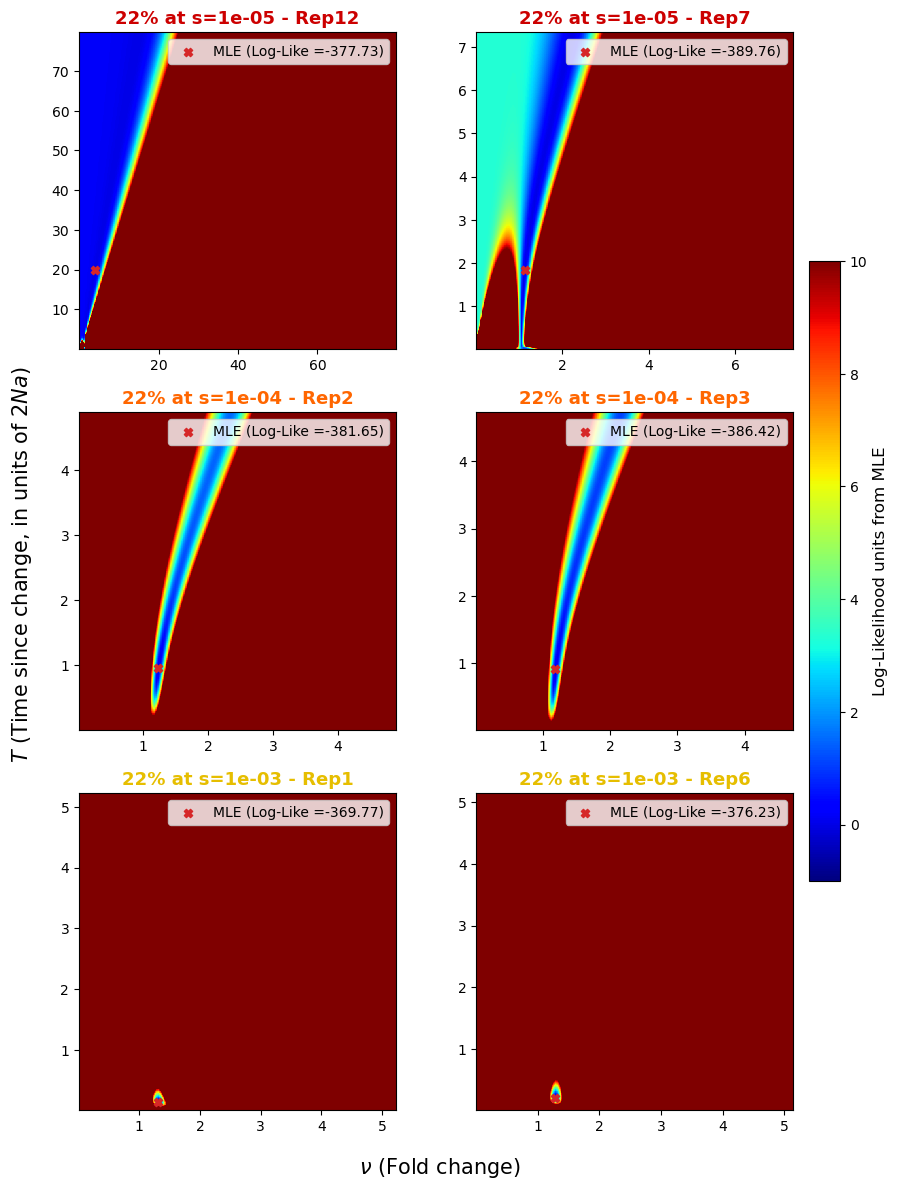

In [8]:
conditions_to_plot = ['E5_Partial_Rep12', 'E5_Partial_Rep7', 'E4_Partial_Rep2',
 'E4_Partial_Rep3', 'E3_Partial_Rep1', 'E3_Partial_Rep6']

fig, axes = plt.subplots(3, 2, figsize=(10, 14))
axes = axes.flatten()

# Shared colormap and normalization
norm = Normalize(vmin=like_min_rescaled, vmax=like_max_rescaled)
cmap = cm.get_cmap(color_scheme)

for ax, dataid in zip(axes, conditions_to_plot):
    #Access the data
    Z_rescaled=loglike_surfaces_rescaled[dataid]
    X_unique = x_values[dataid]
    Y_unique = y_values[dataid]
    input_nu, input_tau = inferred_dem_params[dataid]
    likelihood_model = likelihood_mle[dataid]


    ax.imshow(Z_rescaled ,cmap=cmap, norm=norm, origin='lower', aspect='equal',\
            extent = [min(X_unique), max(X_unique), min(Y_unique), max(Y_unique)])

    #Add the true value
    ax.scatter(input_nu, input_tau, color='C3', marker='X', s=35, label=f"MLE (Log-Like ={likelihood_model:.2f})")
    ax.legend()

    #Create the title 
    condition = map_dataid_condition[dataid]
    rep_id = dataid.split('_')[-1]
    ax.set_title(f"{title_conditions[condition]} - {rep_id}", fontsize=13, color=color_conditions[condition], weight='bold')


#Set y and x labels grid-wide
fig.supxlabel(r"$\it{\nu}$ (Fold change)", fontsize=15, y=0.06)
fig.supylabel(r"$\it{T}$ (Time since change, in units of $\it{2Na}$)", fontsize=15, x=0.07)

#Make a grid-wide colorbar

#Set the title

# Create a ScalarMappable for the colorbar
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cb = fig.colorbar(mappable, ax=axes, orientation='vertical', fraction=0.04, pad=0.02)
cb.set_label('Log-Likelihood units from MLE', fontsize=12)


plt.savefig('SuppFig16B_LogLikeSurfaces.png', dpi=300, bbox_inches='tight')

### Generate all surfaces

In [9]:
#Load all surface data
plotting_replicates={'Zero':np.arange(1,21), 
                    'E5':np.arange(1,21), 
                    'E4':np.arange(1,21), 
                    'E5_Partial':np.arange(1,21), 
                    'E4_Partial':np.arange(1,21), 
                    'E3_Partial':np.arange(1,21)}


In [10]:
#Dic with the shape {'condition_dadioutput':[rep_number, rep_number, ...]}
#plotting_replicates={'Zero':[4, 1], 'E5':[5, 8], 'E4':[3, 9], 'E5_Partial':[12, 7], 'E4_Partial':[2, 3], 'E3_Partial':[1, 6]}

#All the loglike surfaces and other parameters. Data identified as "condition_dadioutput_Rep{rep_number}"
inferred_dem_params={}
likelihood_mle={}
loglike_surfaces={}
loglike_surfaces_rescaled={}
x_values={}
y_values={}
map_dataid_condition={}

all_dataids=[]
missing_dataids=[]

for condition in plotting_replicates.keys():
    for rep in plotting_replicates[condition]:
        dataid=f"{condition}_Rep{rep}"
        print(f"Processing {dataid}...")
        map_dataid_condition[dataid]=condition
        all_dataids.append(dataid)

        #Get the originally inferred demographic parameters
        input_file_demography=f"/u/project/klohmuel/amzurita/Synonimous_Selection_Simulations/Dadi_Fits/DadiFits_OutputFiles_BugFix/{condition}_TwoEpoch_Replicate{rep}_two_epoch_demography.txt"
      
        with open(input_file_demography, 'r') as file:
            for line in file:
                if 'Maximum multinomial log composite likelihood: ' in line:
                    parsed_params=line.strip().strip('.').split(': ')[1]
                    print(parsed_params)
                    likelihood_model=float(parsed_params)
                    likelihood_mle[dataid]=likelihood_model
                elif 'Best fit parameters: ' in line:
                    parsed_params=line.strip().strip('.').split(': ')[1]
                    parsed_params=parsed_params.strip('[').strip(']')
                    demog_params=[float(x.strip(',')) for x in parsed_params.split()]
                    print(demog_params)
                    inferred_dem_params[dataid]=demog_params


        #Load the loglike surface
        try:
            df=pd.read_csv(f"/u/project/klohmuel/amzurita/Synonimous_Selection_Simulations/Dadi_Fits/DadiFits_OutputFiles_BugFix/likelihood_surface_{condition}_Replicate{rep}.csv", index_col=0)
        except FileNotFoundError:
            print(f"File not found for {dataid}. Skipping...")
            missing_dataids.append(dataid)
            continue
        input_nu, input_tau = demog_params

        like_max = abs(likelihood_model)+10
        like_min = abs(likelihood_model)-10    

        #Prepare the data
        Z = df.pivot_table(index='X', columns='Y', values='Z').T.values
        X_unique = np.sort(df.X.unique())
        Y_unique = np.sort(df.Y.unique())
        X, Y = np.meshgrid(X_unique, Y_unique)

        #Store the x and y values for plotting
        x_values[dataid] = X_unique
        y_values[dataid] = Y_unique

        #Plotting with a log scale color gradient
        Z = np.abs(Z)  # Ensure all values are positive, for log scaling.

        #Rescale with respect to the maximum likelihood
        Z_rescaled = Z - abs(likelihood_model)

        loglike_surfaces[dataid] = Z
        loglike_surfaces_rescaled[dataid] = Z_rescaled

Processing Zero_Rep1...
[1.04342915, 0.52922326]
-383.76912957863703
Processing Zero_Rep2...
[1.06441384, 0.03998692]
-385.59332217295014
Processing Zero_Rep3...
[1.10851926, 1.29216266]
-387.87189741300654
Processing Zero_Rep4...
[1.05112303, 0.29287213]
-385.93556972426063
Processing Zero_Rep5...
[0.001, 2.94961303e-07]
-390.71095844341534
File not found for Zero_Rep5. Skipping...
Processing Zero_Rep6...
[1.03044811, 0.24090749]
-389.54200652980137
Processing Zero_Rep7...
[11.5567058, 0.000365118085]
-404.33323205989313
File not found for Zero_Rep7. Skipping...
Processing Zero_Rep8...
[1.49495339, 4.59522954]
-383.08064080451464
Processing Zero_Rep9...
[1.08614759, 0.5685428]
-392.79722431114624
Processing Zero_Rep10...
[1.02181621, 0.37970414]
-381.3425702173101
Processing Zero_Rep11...
[4.89948689, 20.0]
-379.462453456617
Processing Zero_Rep12...
[1.06602004, 0.07009572]
-374.98485454935565
Processing Zero_Rep13...
[1.04225062, 0.26658539]
-383.4065984337033
Processing Zero_Rep14..

Plotting Zero_Rep1...
Plotting Zero_Rep2...
Plotting Zero_Rep3...
Plotting Zero_Rep4...
Plotting Zero_Rep6...
Plotting Zero_Rep8...
Plotting Zero_Rep9...
Plotting Zero_Rep10...
Plotting Zero_Rep11...
Plotting Zero_Rep12...
Plotting Zero_Rep13...
Plotting Zero_Rep14...
Plotting Zero_Rep15...
Plotting Zero_Rep16...
Plotting Zero_Rep17...
Plotting E5_Rep1...
Plotting E5_Rep2...
Plotting E5_Rep3...
Plotting E5_Rep4...
Plotting E5_Rep5...
Plotting E5_Rep6...


/tmp/ipykernel_28118/190968529.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(7, 7))


Plotting E5_Rep7...
Plotting E5_Rep8...
Plotting E5_Rep9...
Plotting E5_Rep10...
Plotting E5_Rep11...
Plotting E5_Rep12...
Plotting E5_Rep13...
Plotting E5_Rep14...
Plotting E5_Rep15...
Plotting E5_Rep16...
Plotting E5_Rep17...
Plotting E5_Rep18...
Plotting E5_Rep19...
Plotting E5_Rep20...
Plotting E4_Rep1...
Plotting E4_Rep2...
Plotting E4_Rep3...
Plotting E4_Rep4...
Plotting E4_Rep5...
Plotting E4_Rep6...
Plotting E4_Rep7...
Plotting E4_Rep8...
Plotting E4_Rep9...
Plotting E4_Rep10...
Plotting E4_Rep11...
Plotting E4_Rep12...
Plotting E4_Rep13...
Plotting E4_Rep14...
Plotting E4_Rep15...
Plotting E4_Rep16...
Plotting E4_Rep17...
Plotting E4_Rep18...
Plotting E4_Rep19...
Plotting E4_Rep20...
Plotting E5_Partial_Rep1...
Plotting E5_Partial_Rep2...
Plotting E5_Partial_Rep3...
Plotting E5_Partial_Rep4...
Plotting E5_Partial_Rep5...
Plotting E5_Partial_Rep6...
Plotting E5_Partial_Rep7...
Plotting E5_Partial_Rep8...
Plotting E5_Partial_Rep9...
Plotting E5_Partial_Rep10...
Plotting E5_Parti

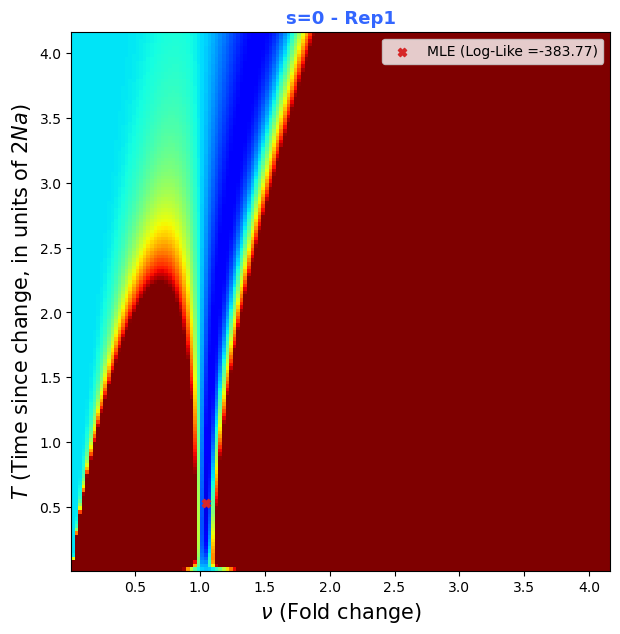

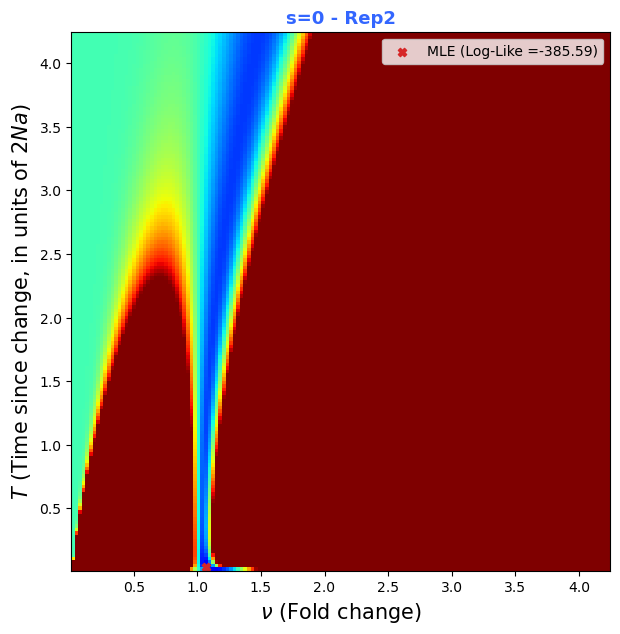

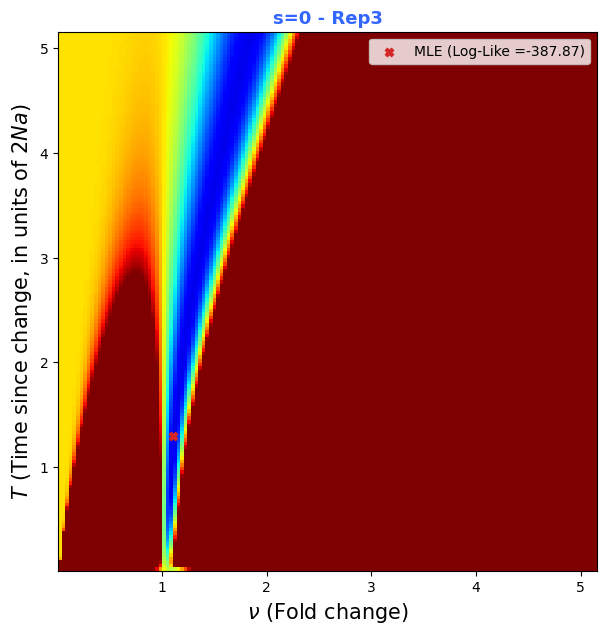

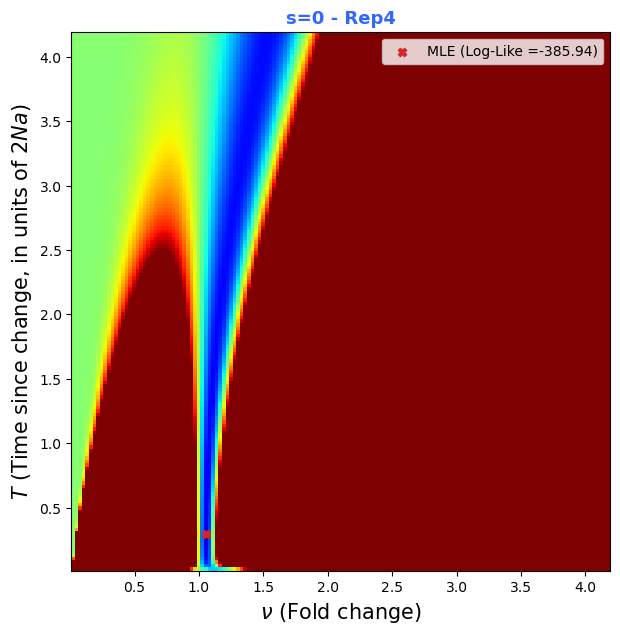

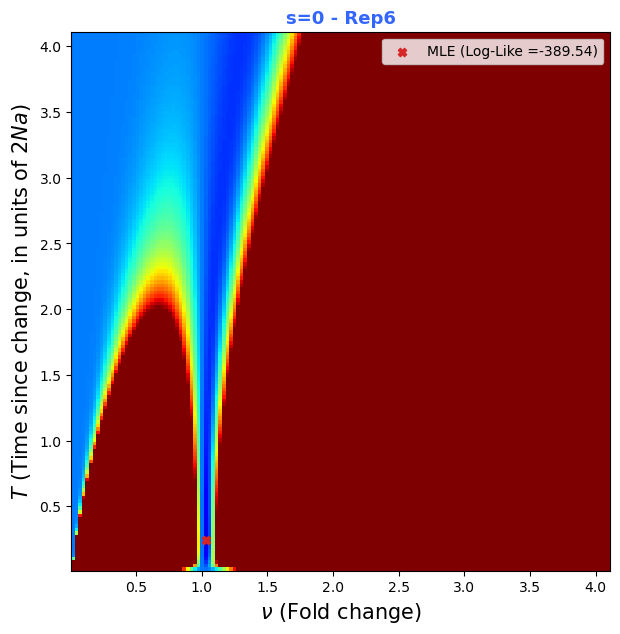

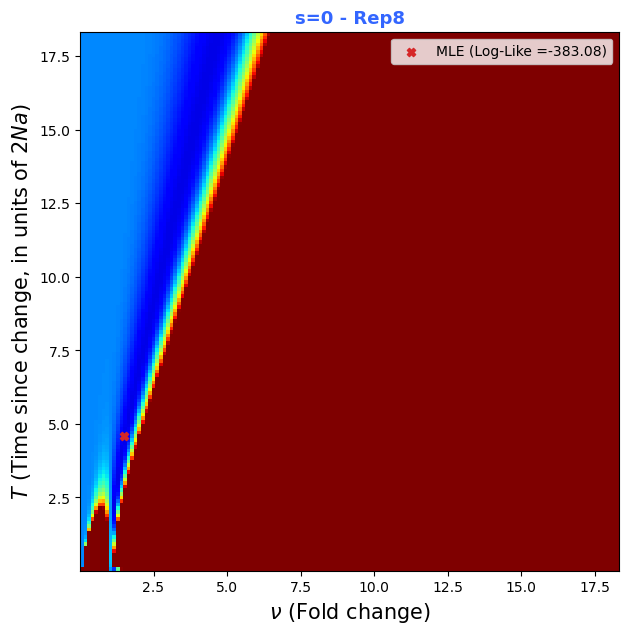

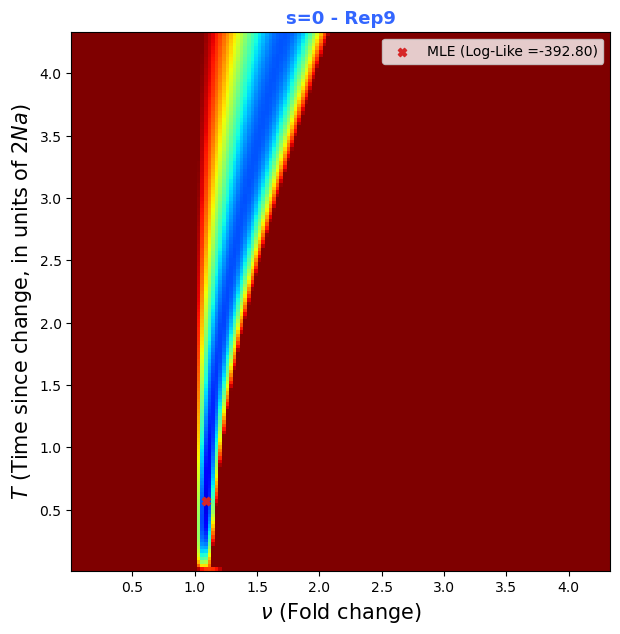

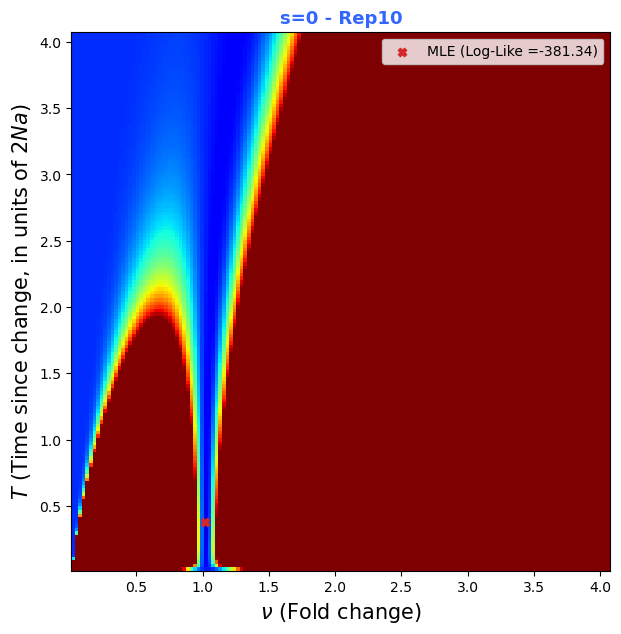

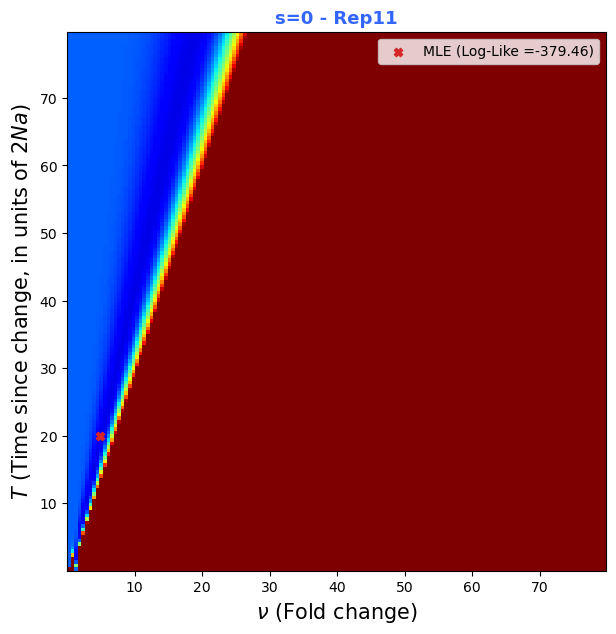

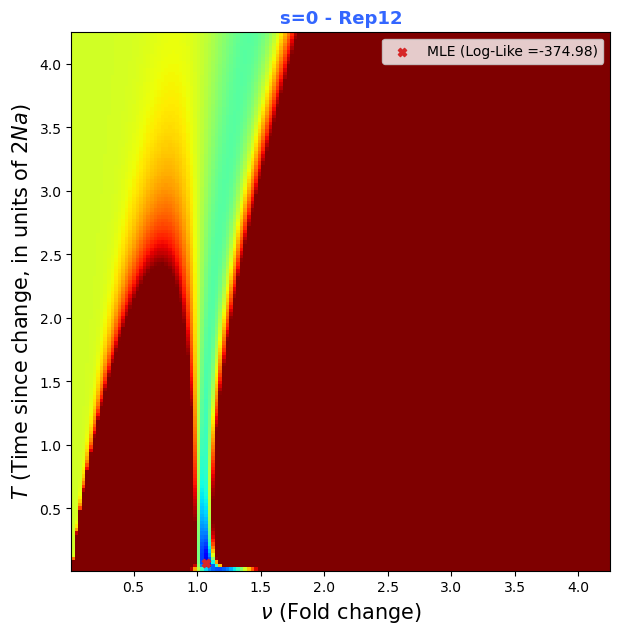

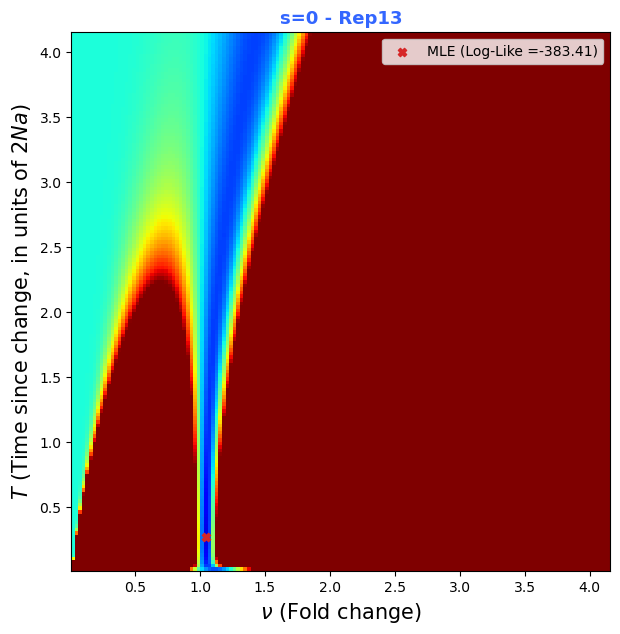

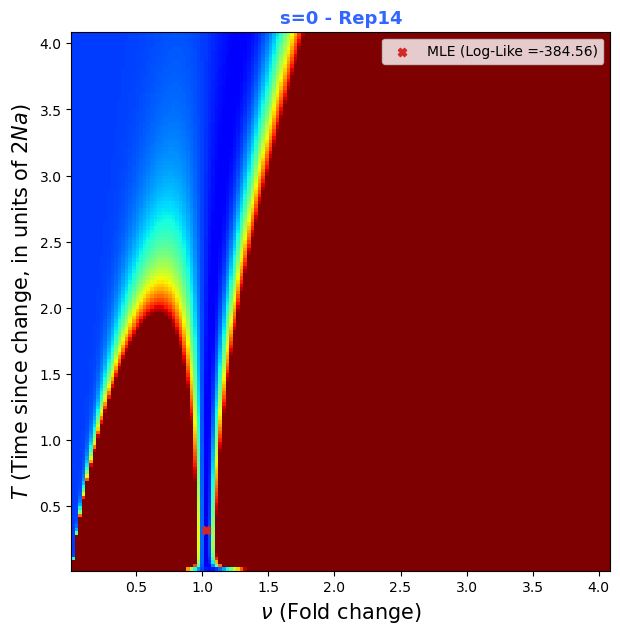

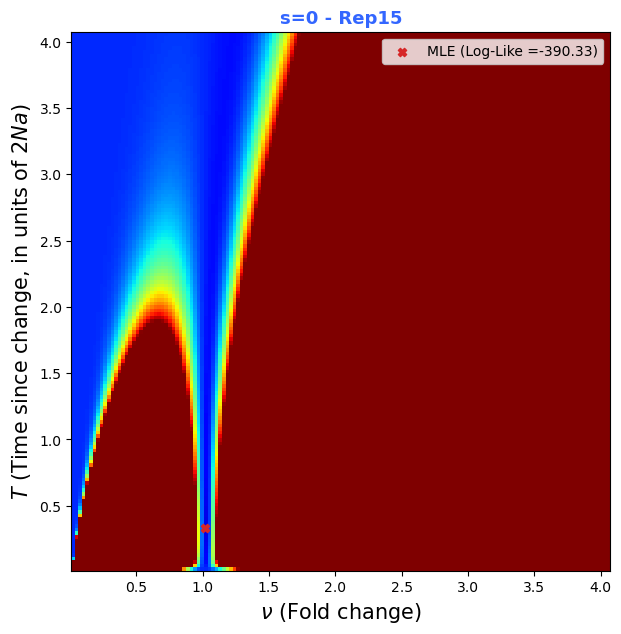

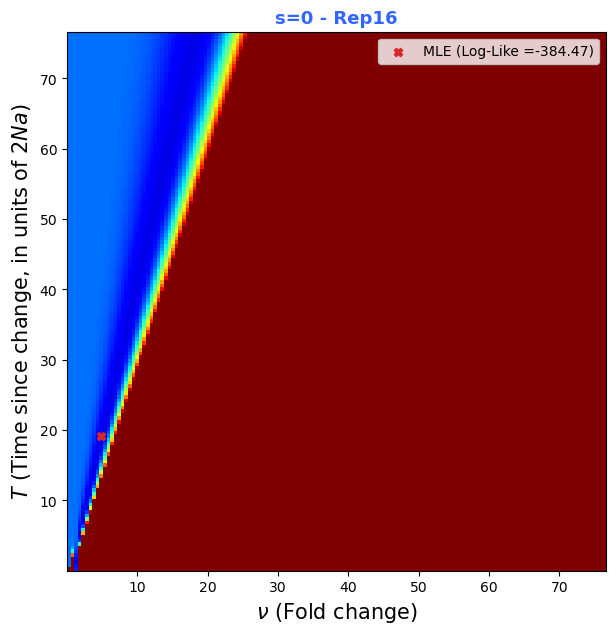

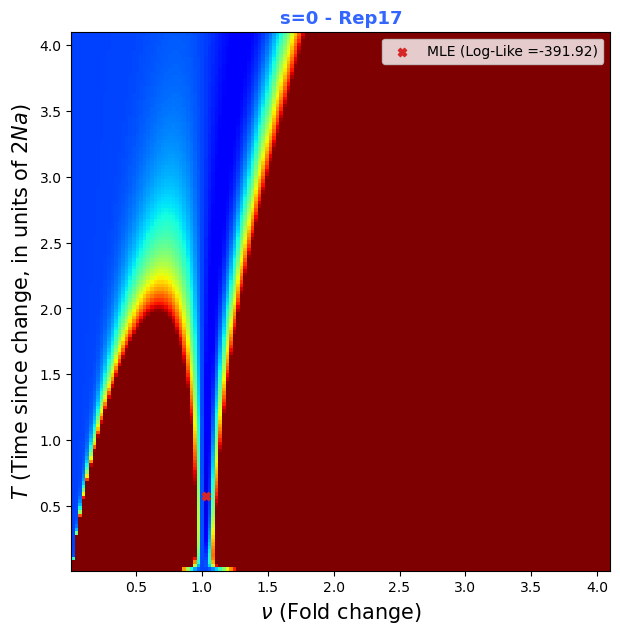

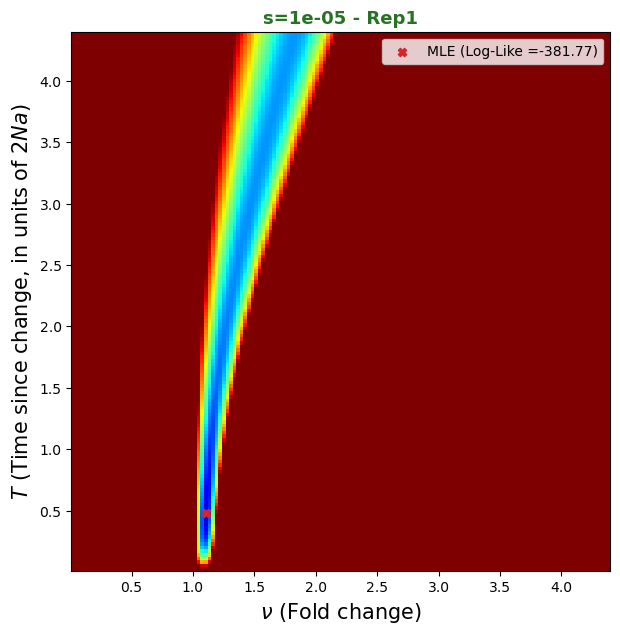

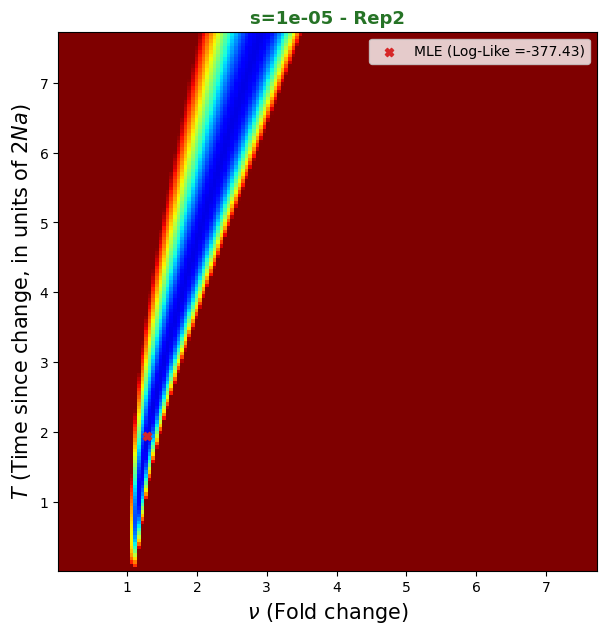

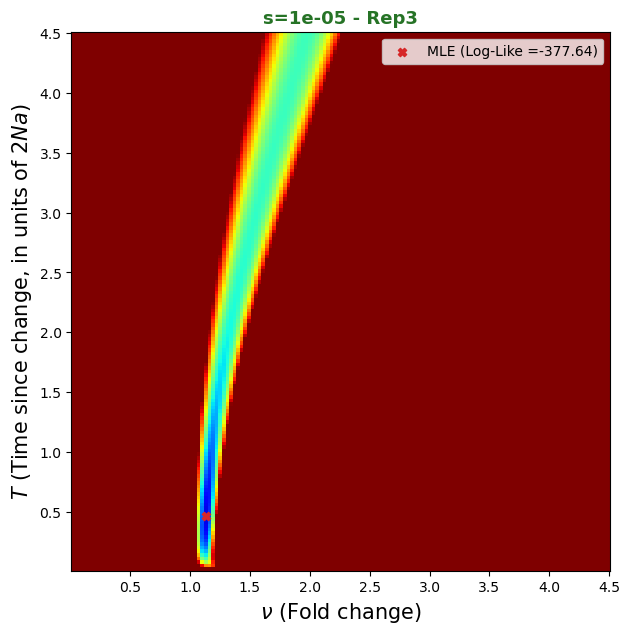

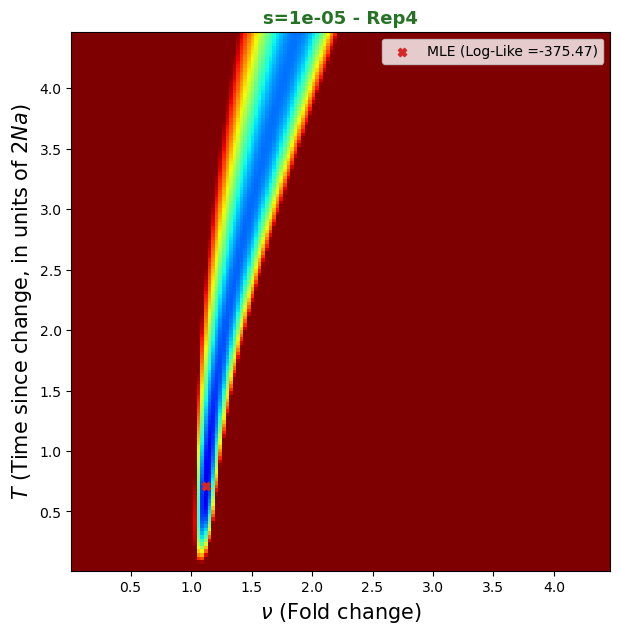

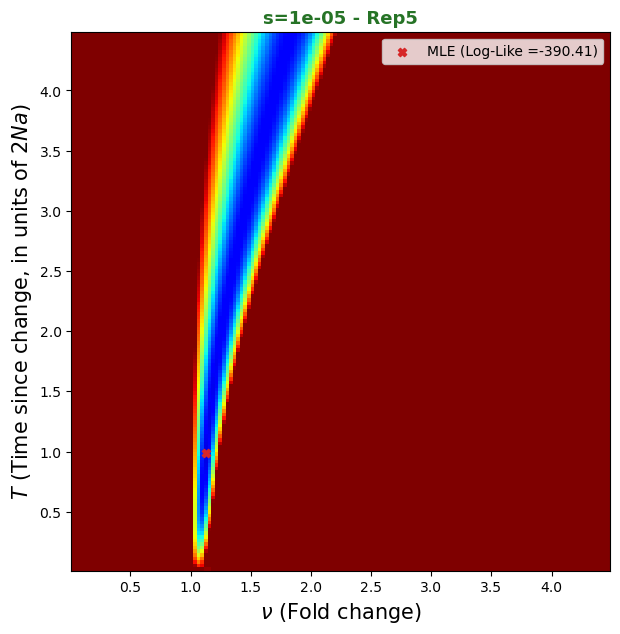

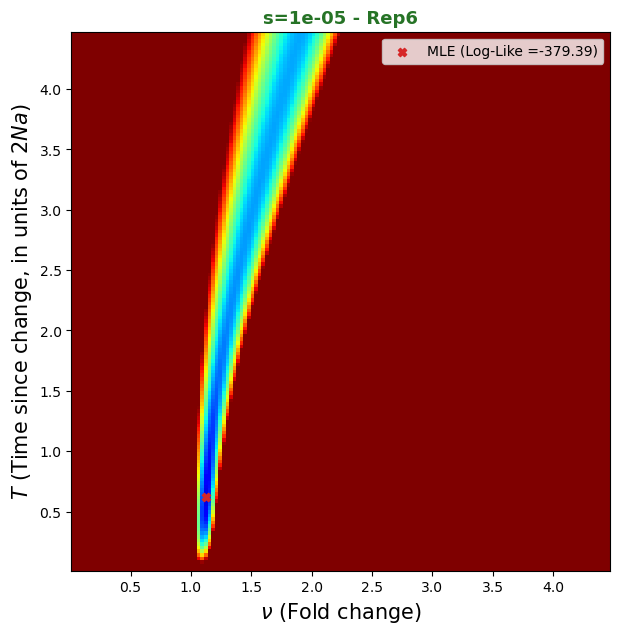

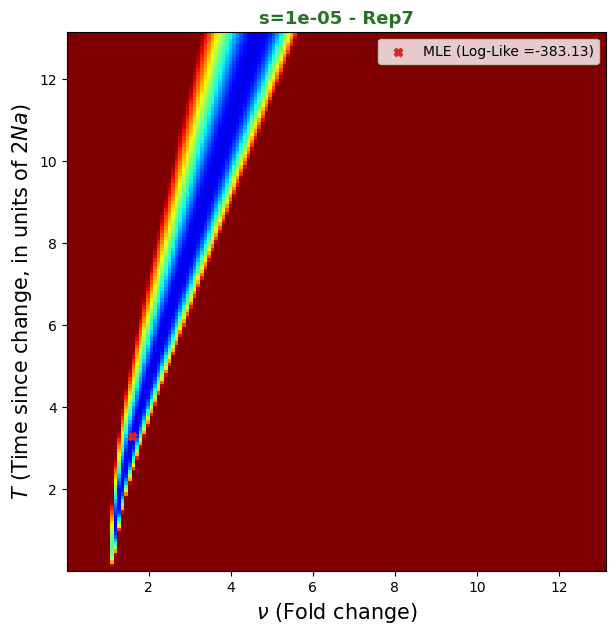

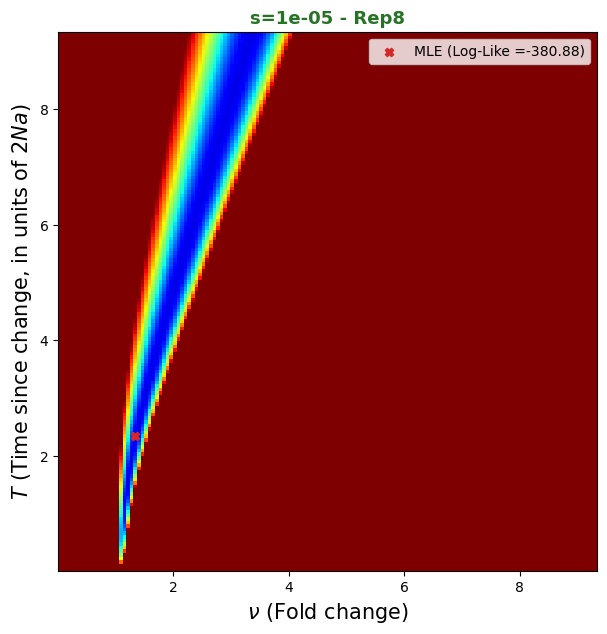

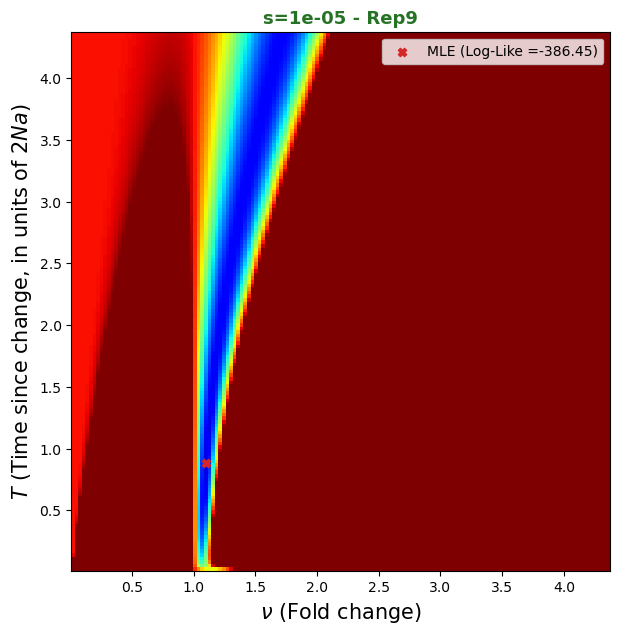

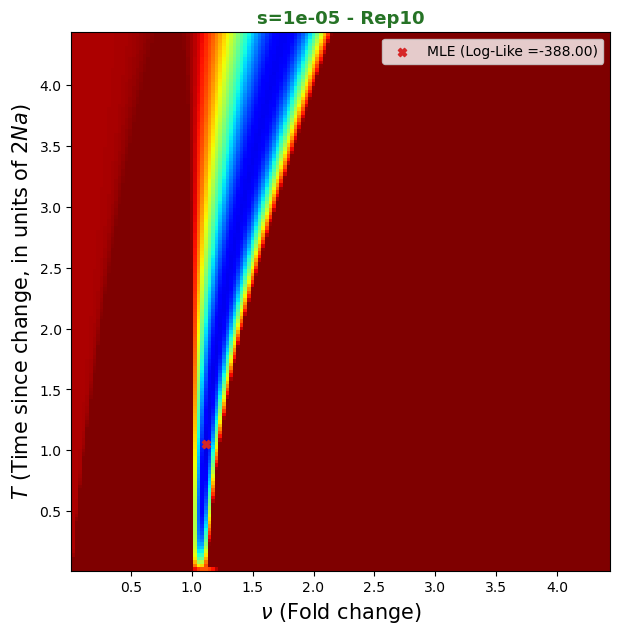

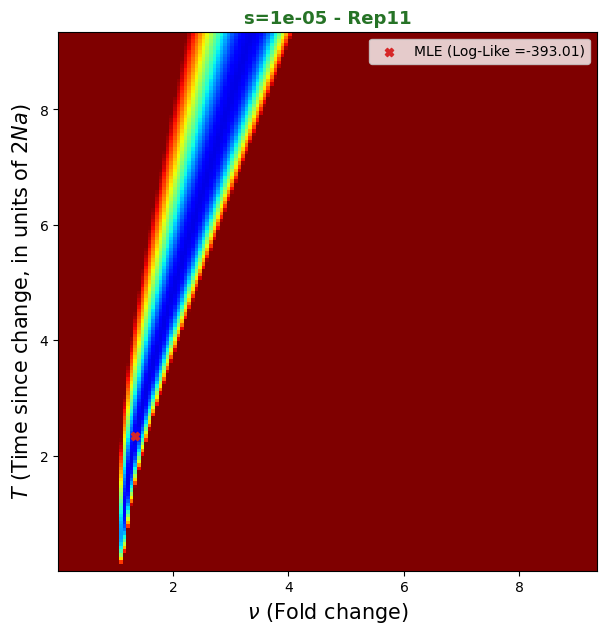

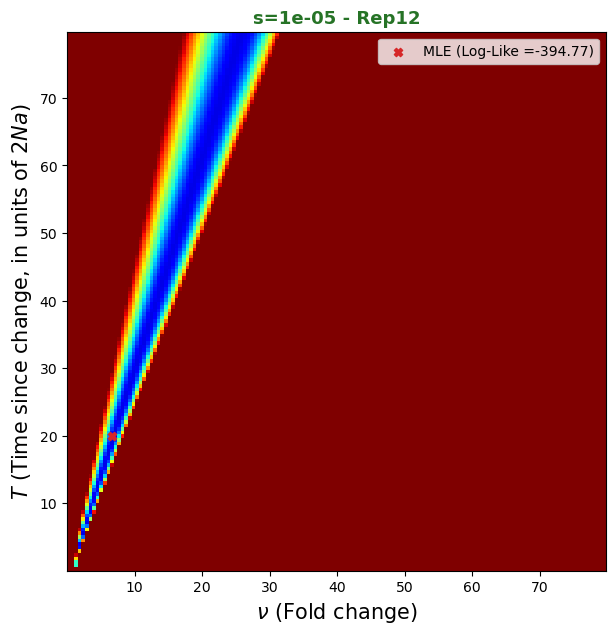

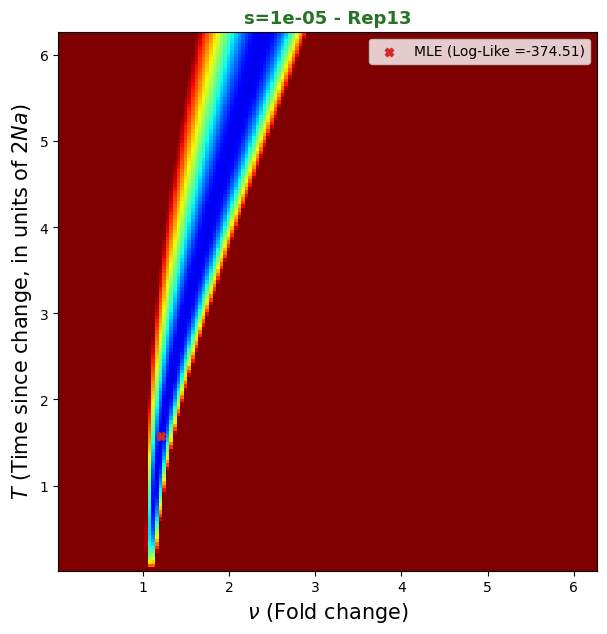

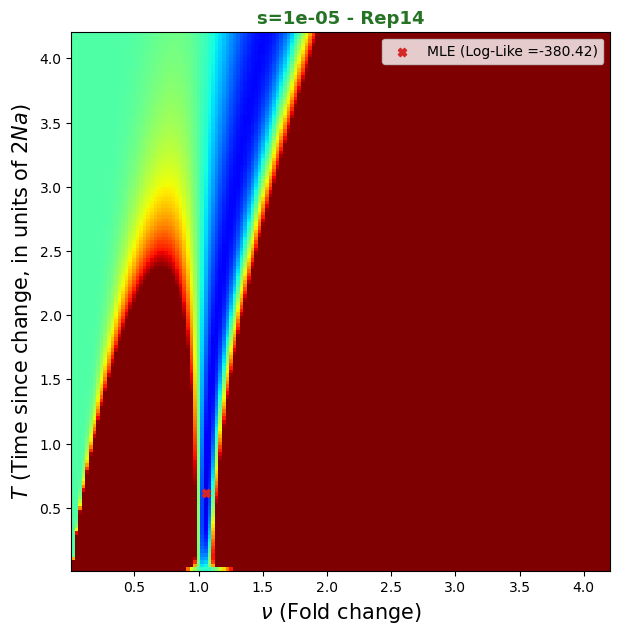

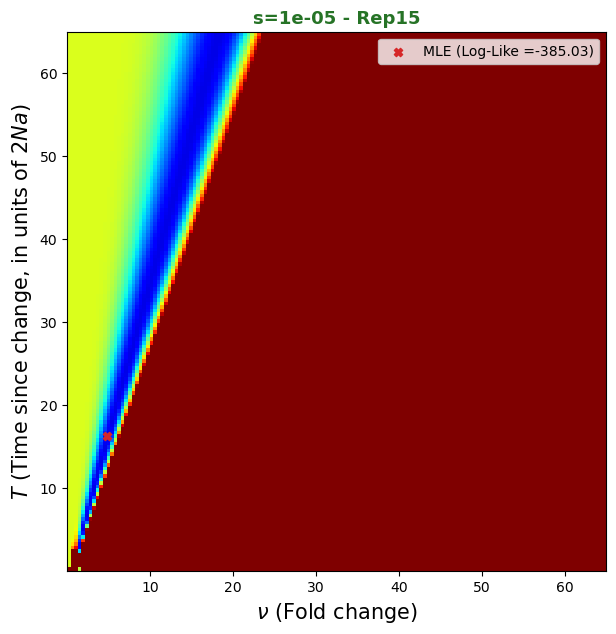

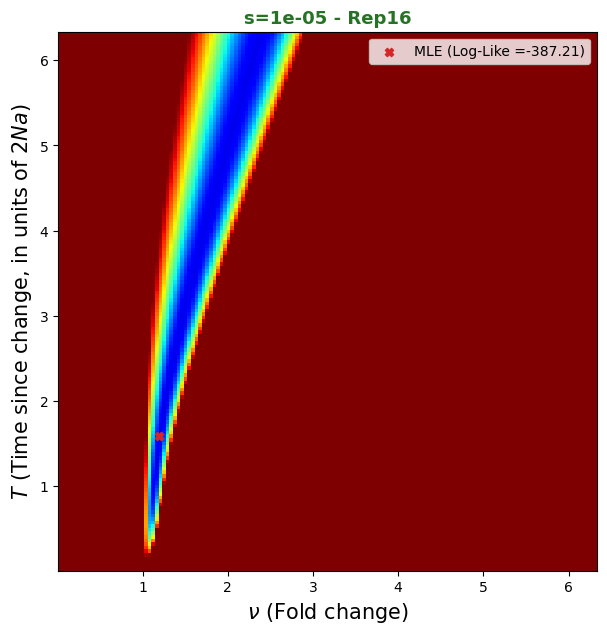

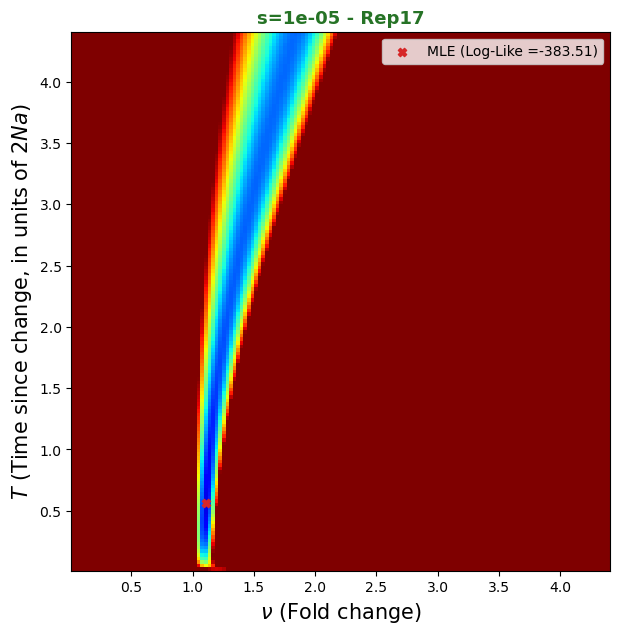

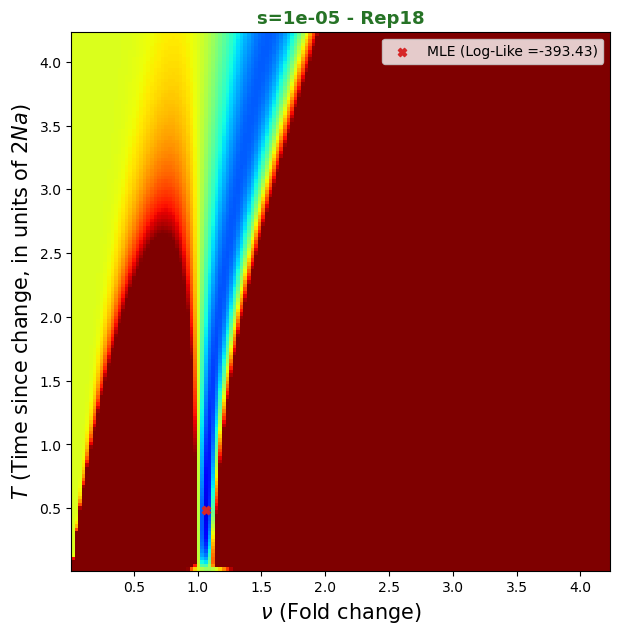

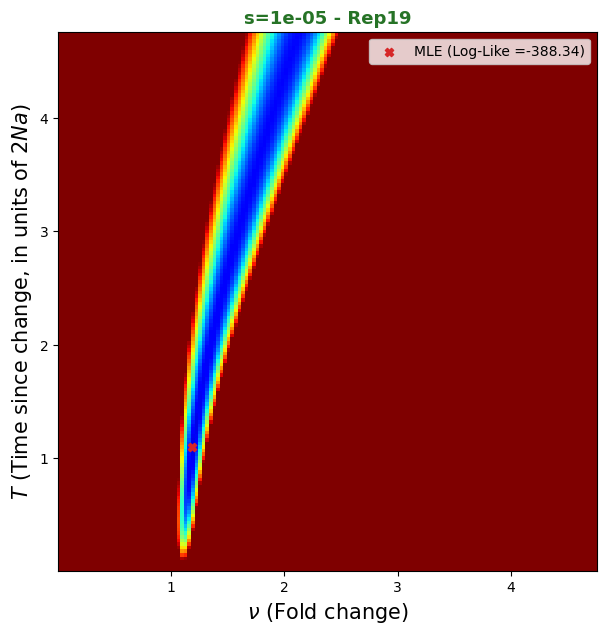

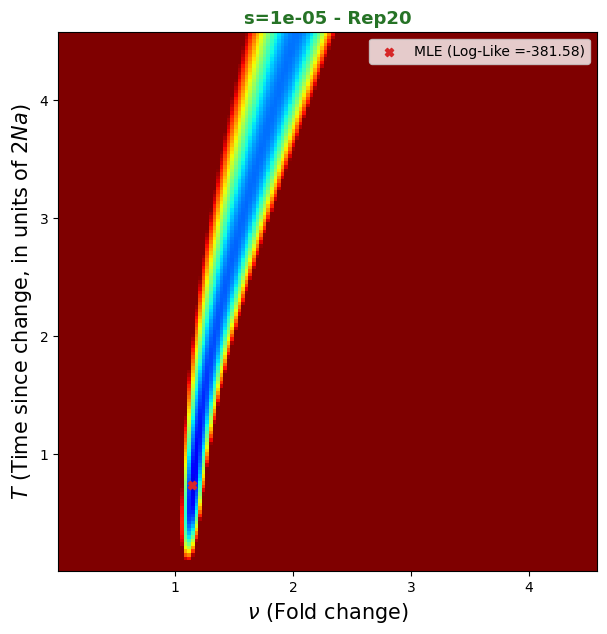

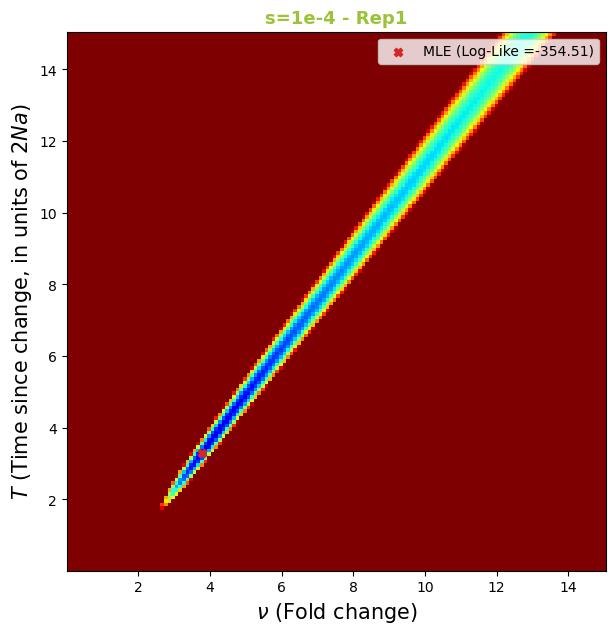

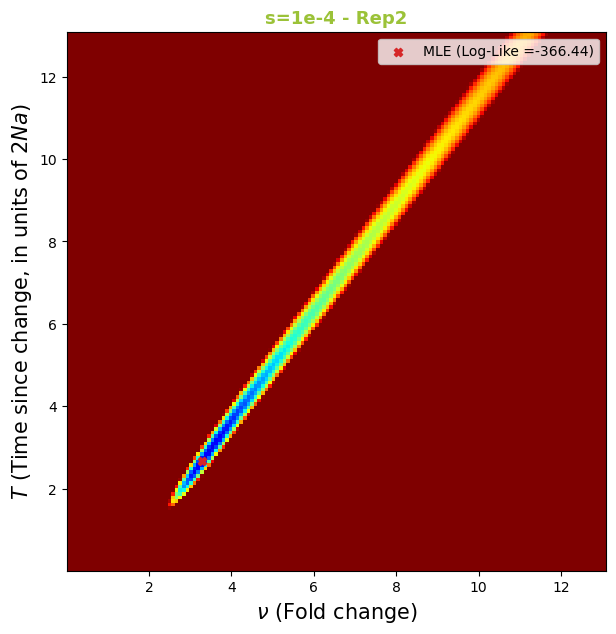

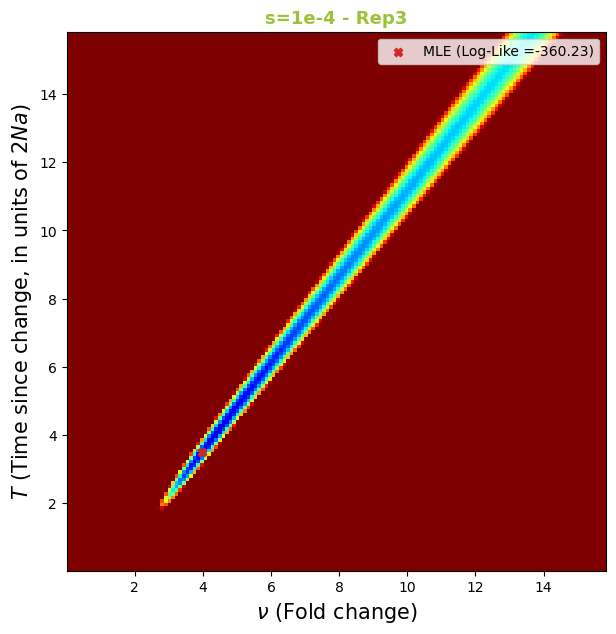

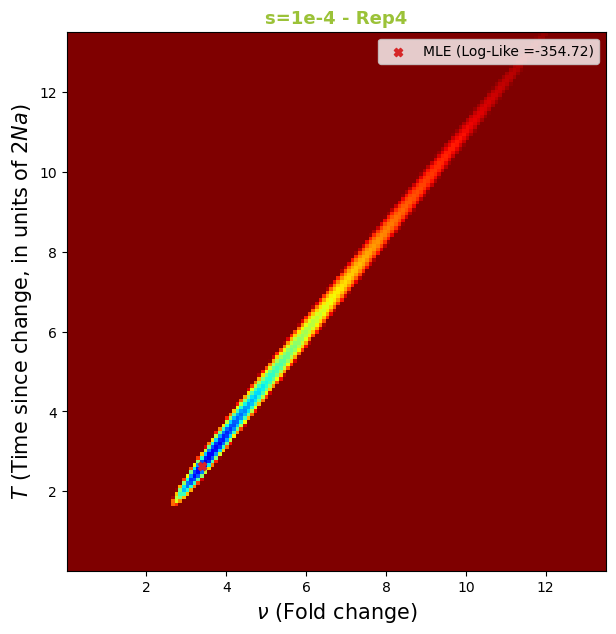

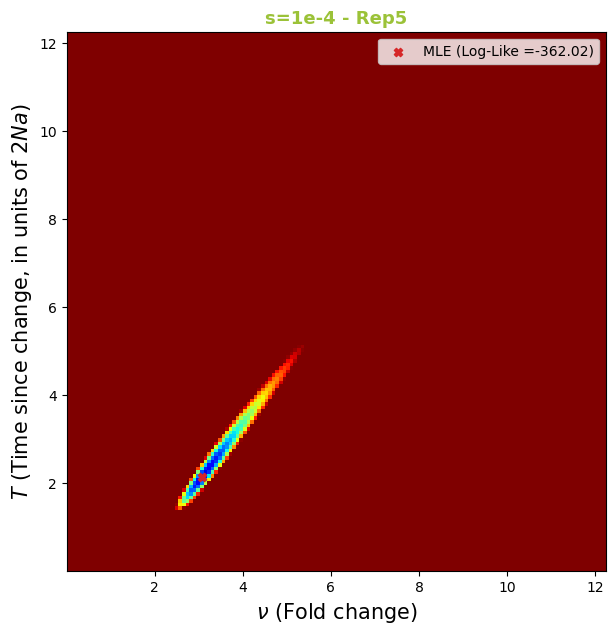

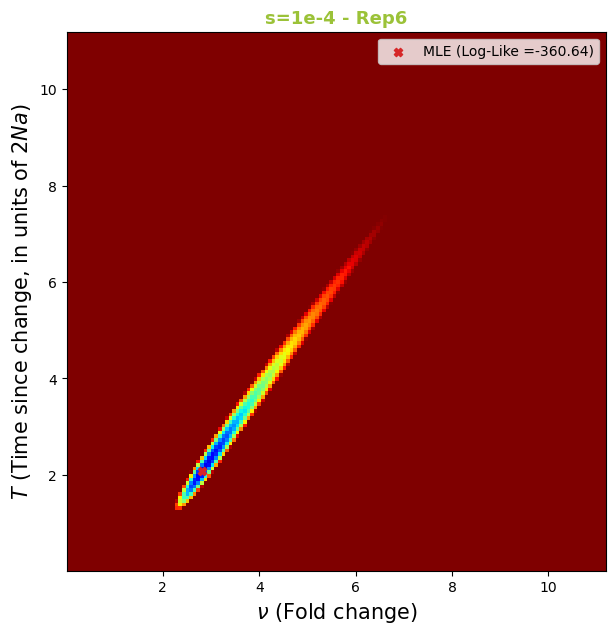

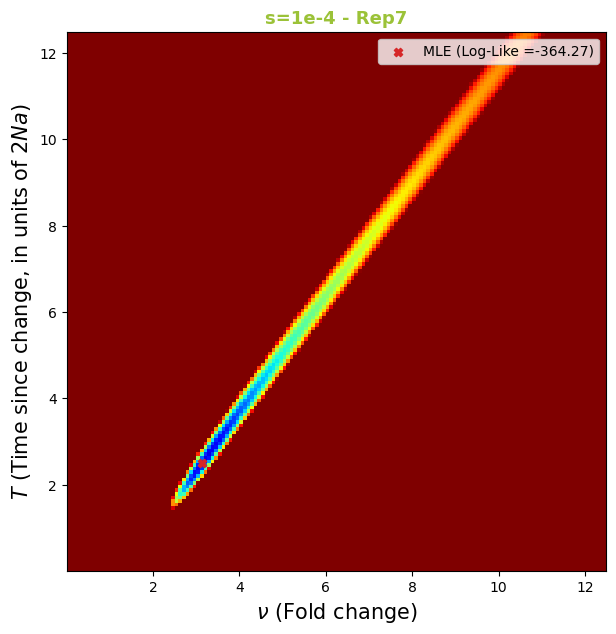

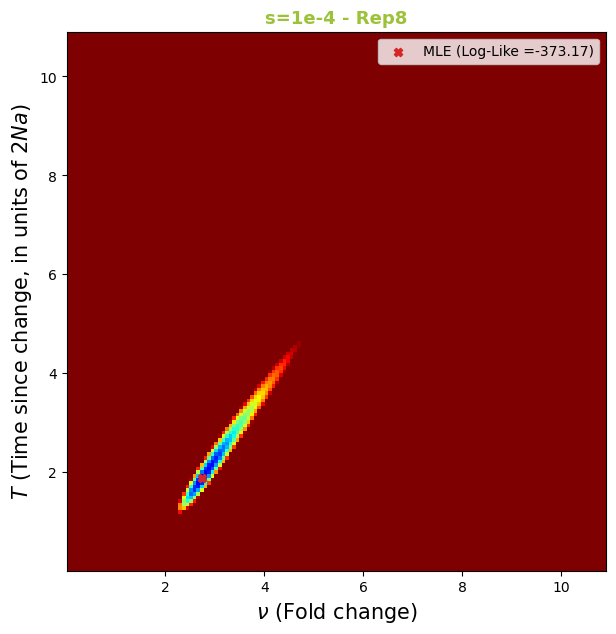

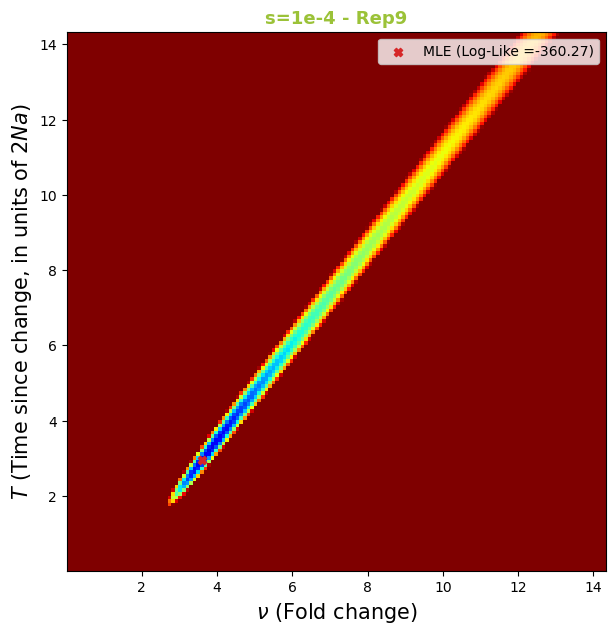

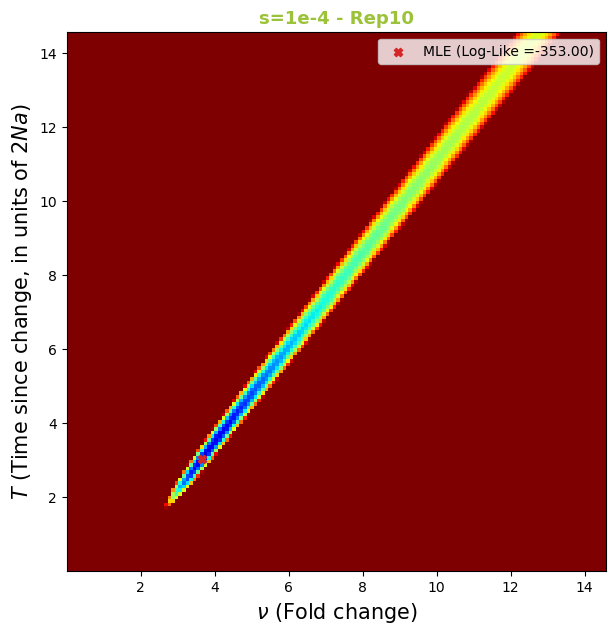

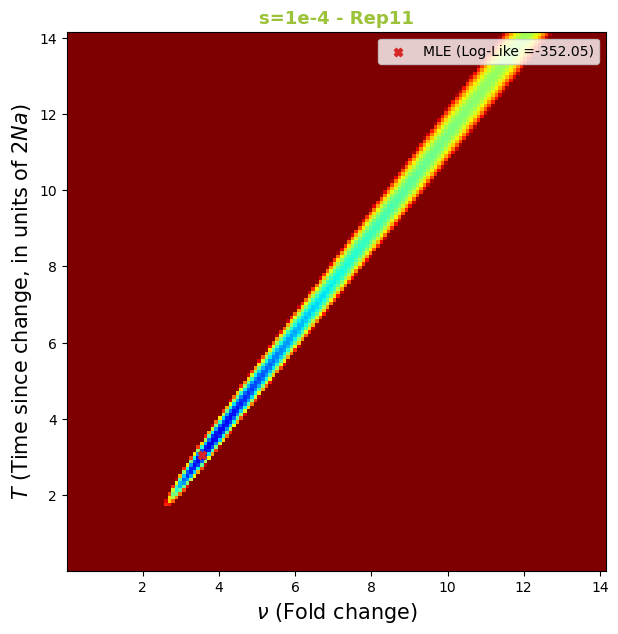

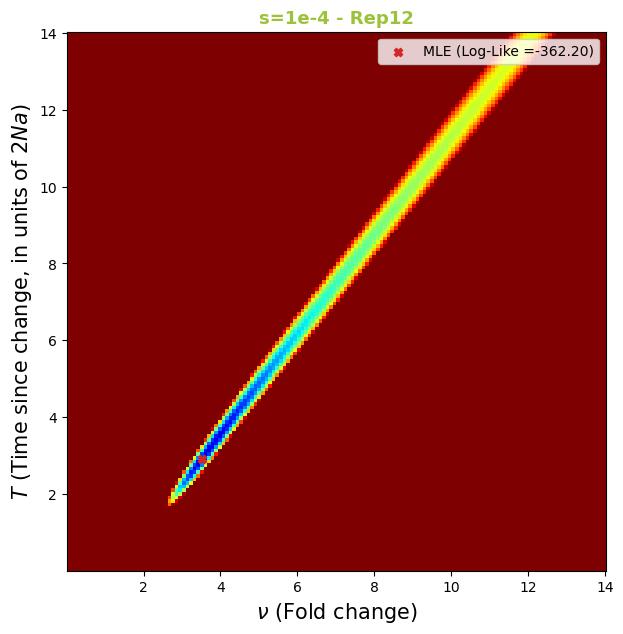

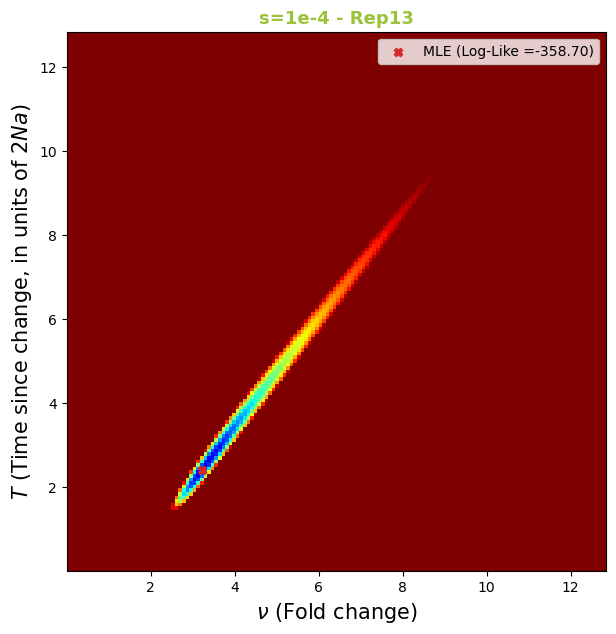

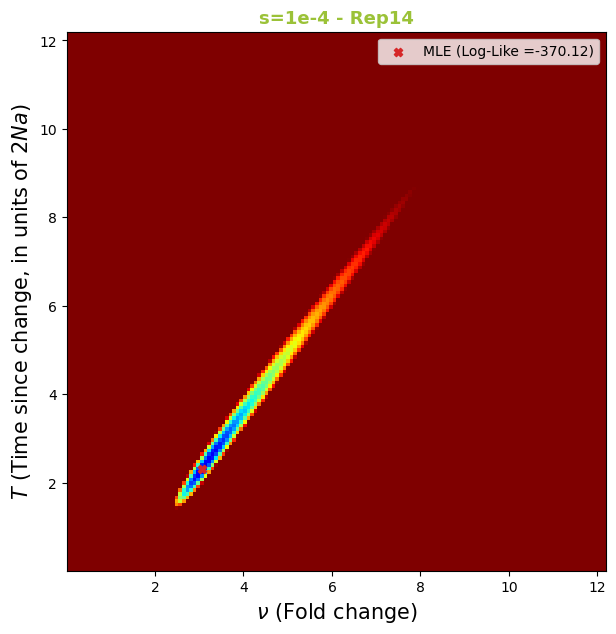

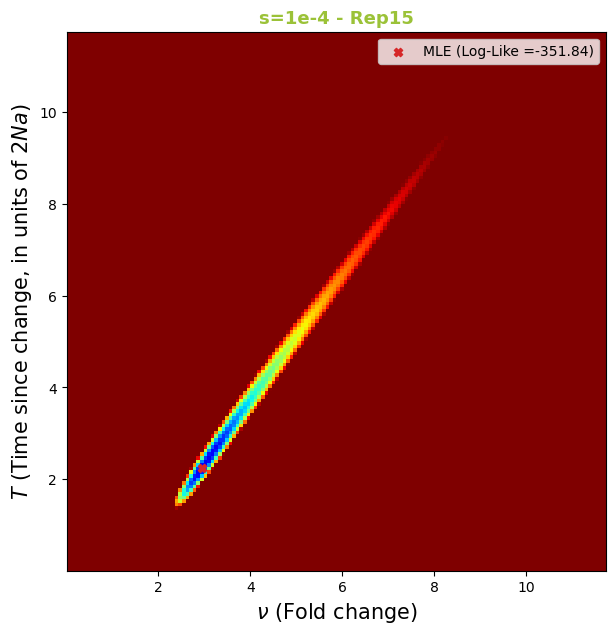

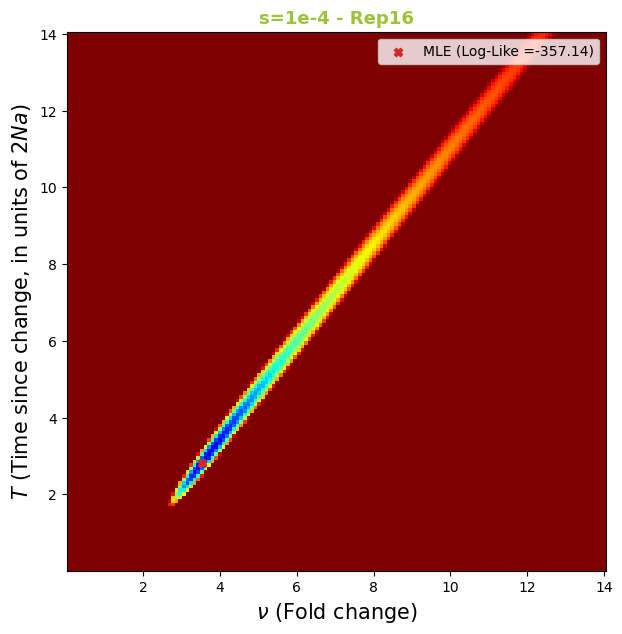

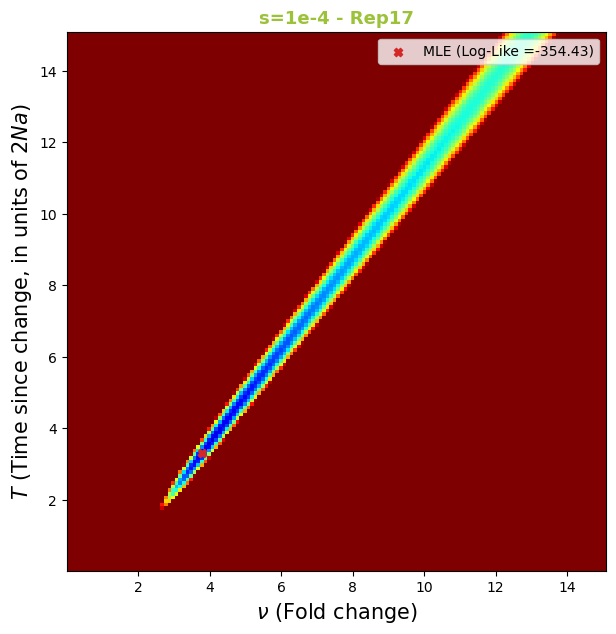

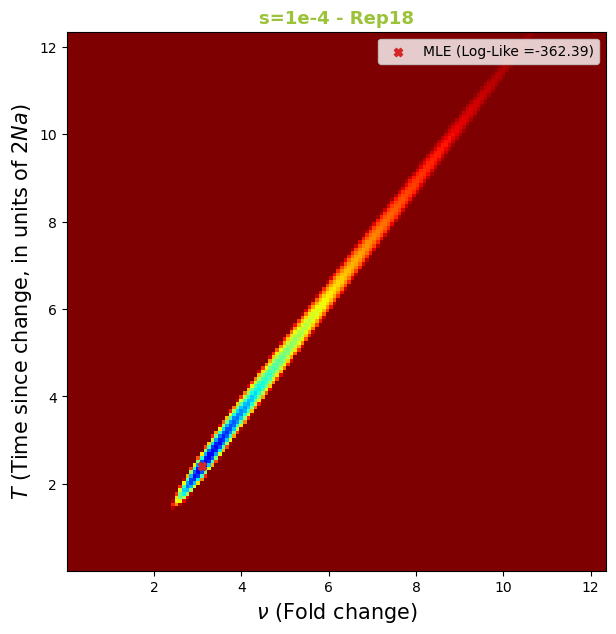

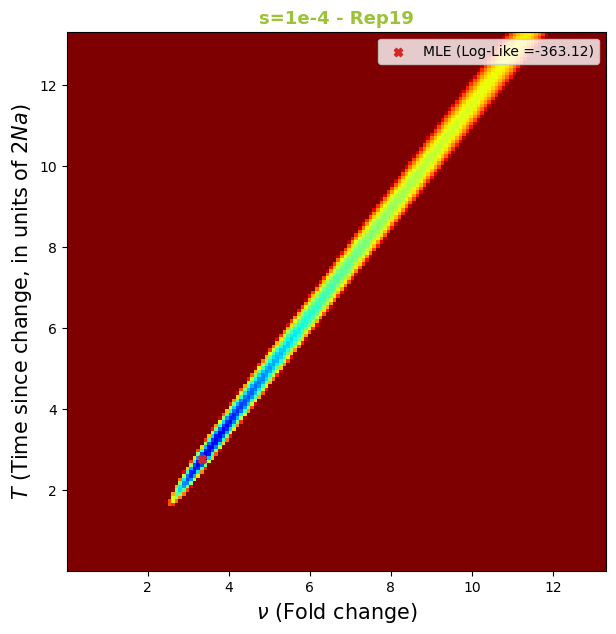

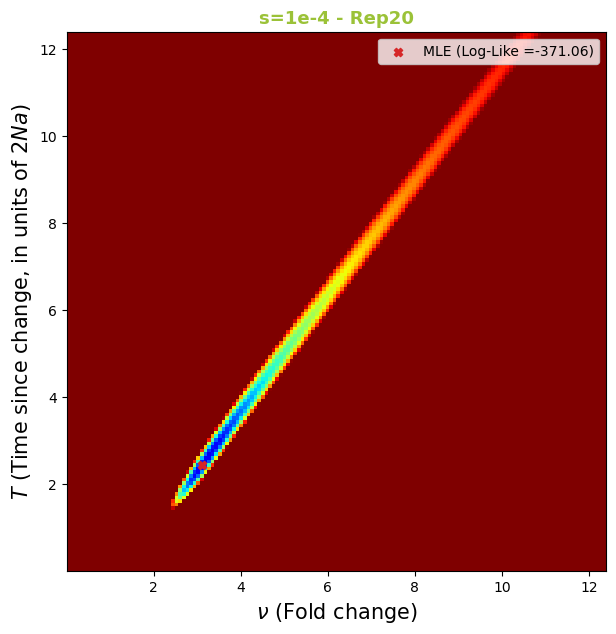

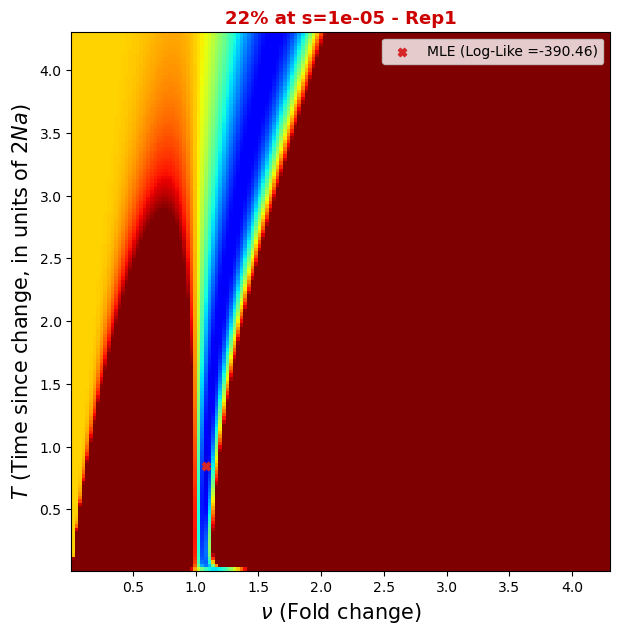

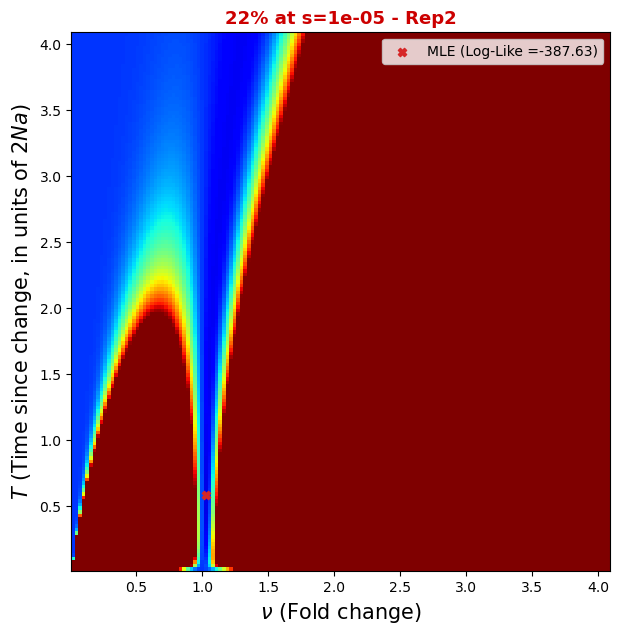

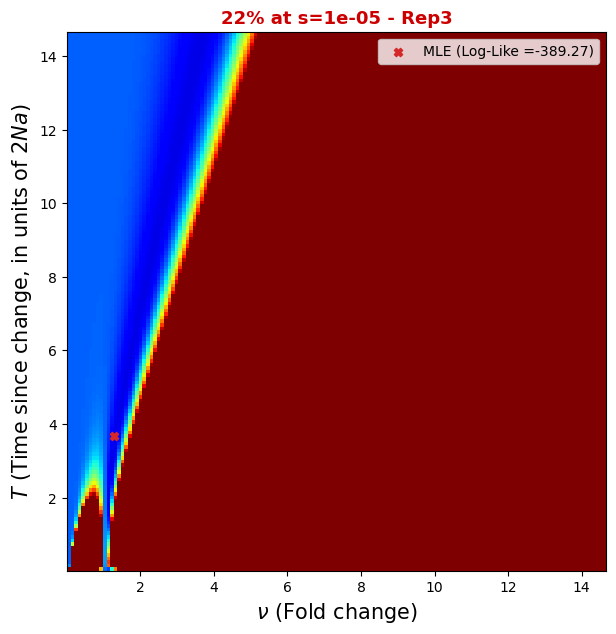

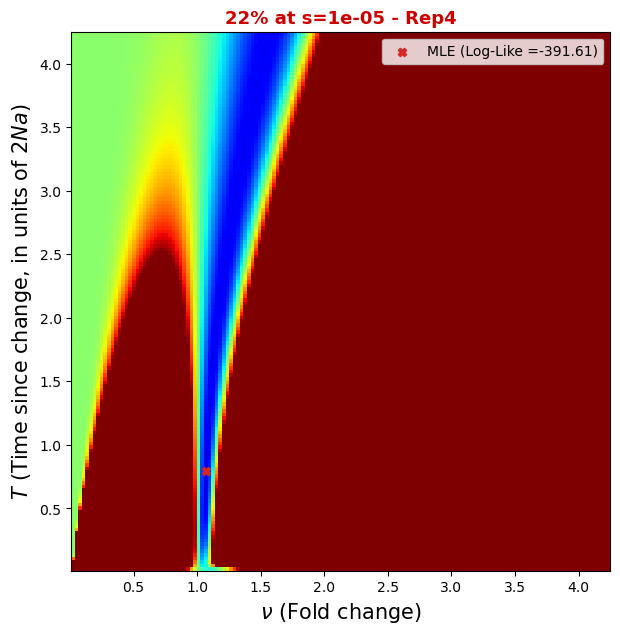

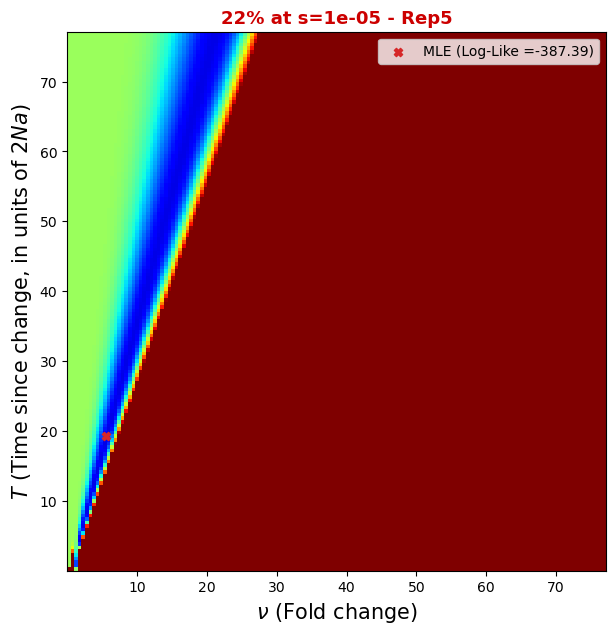

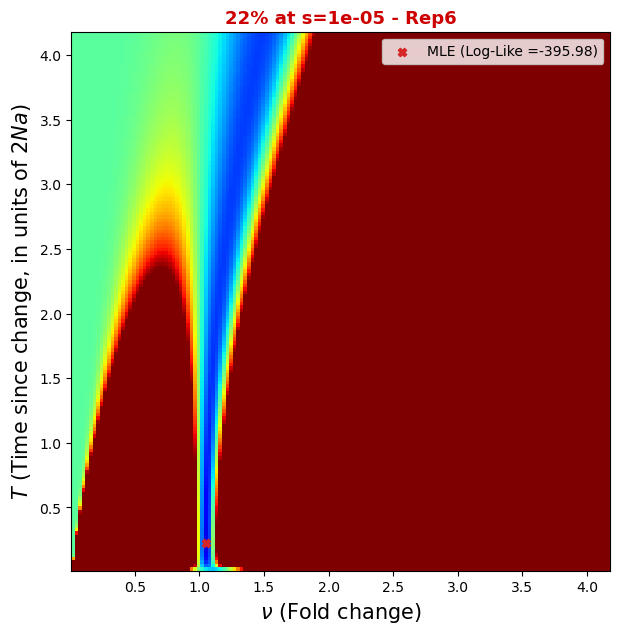

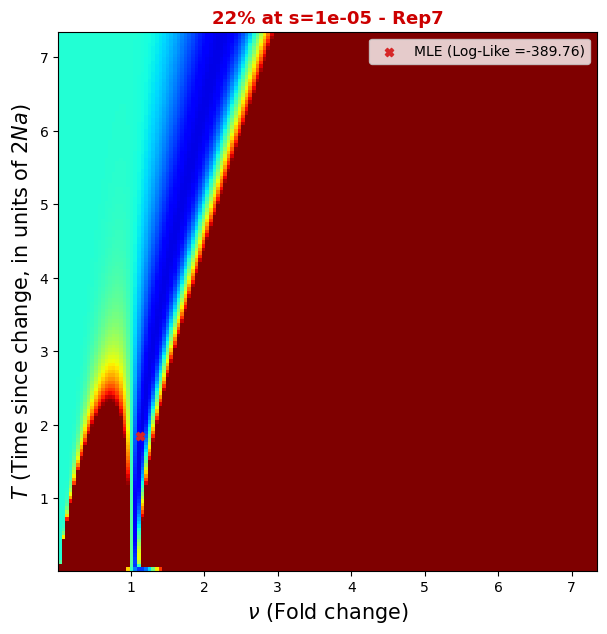

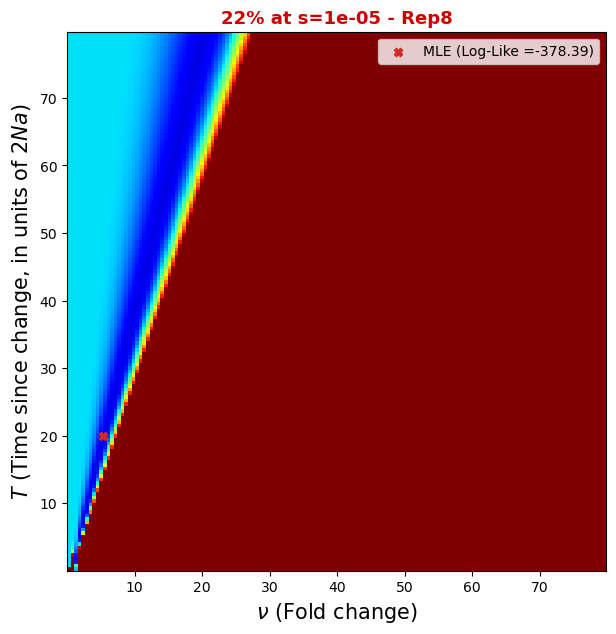

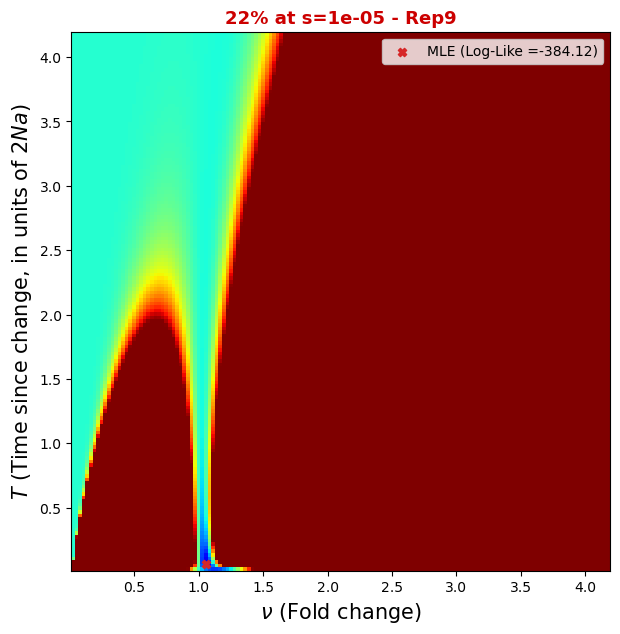

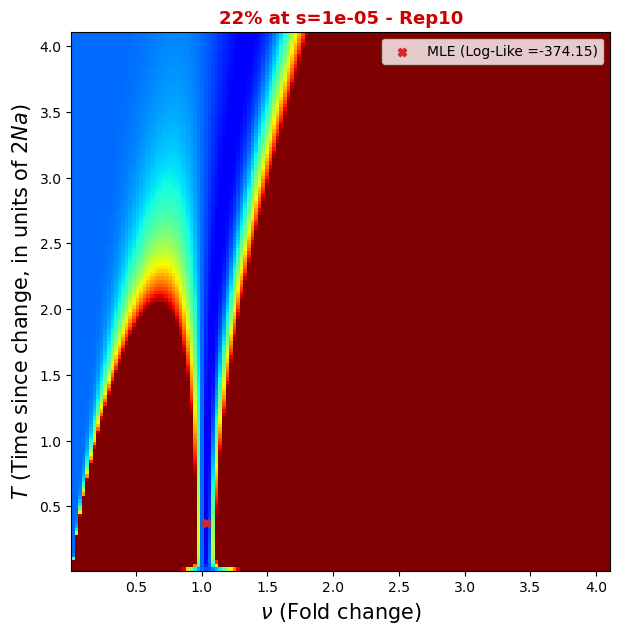

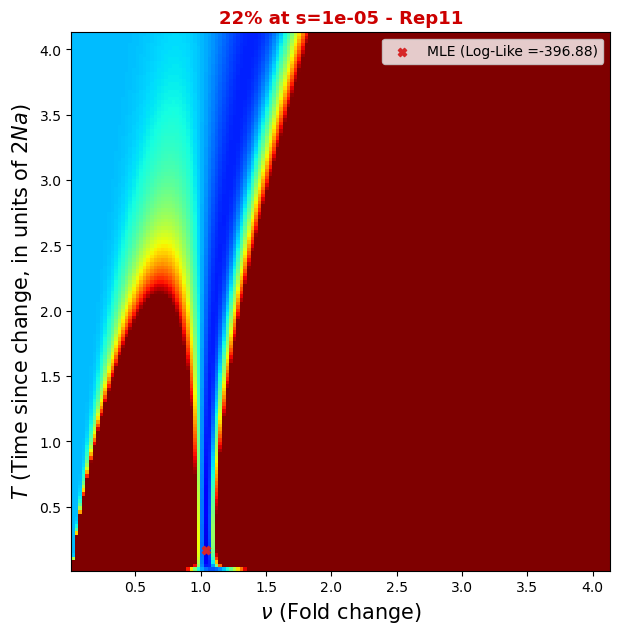

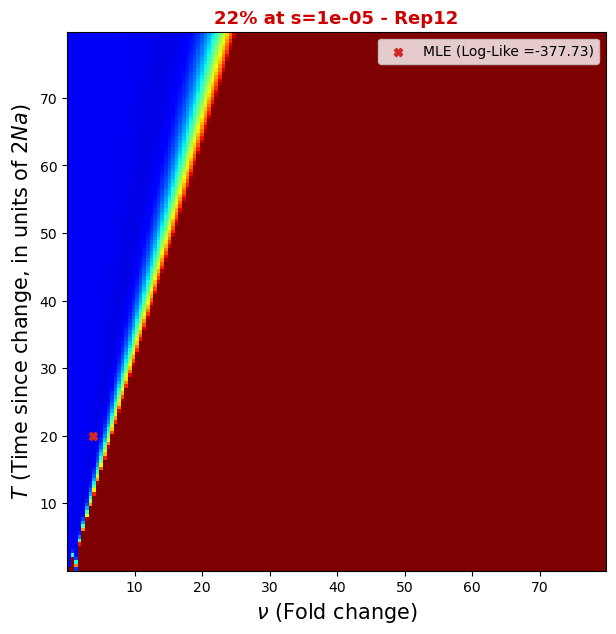

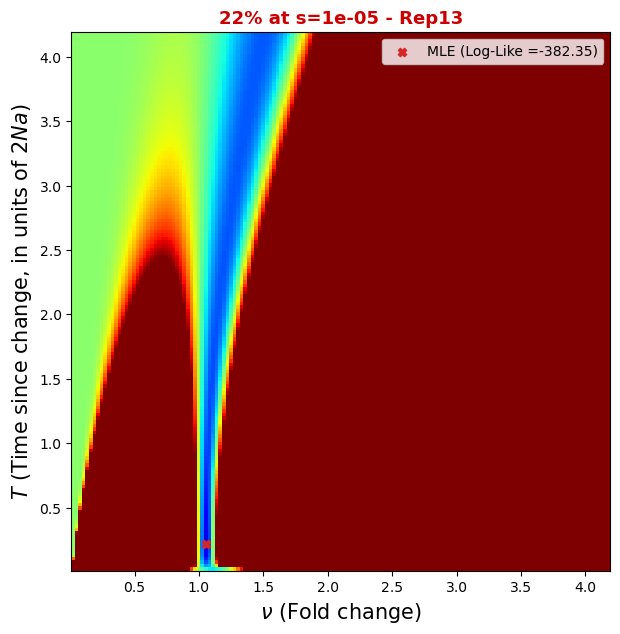

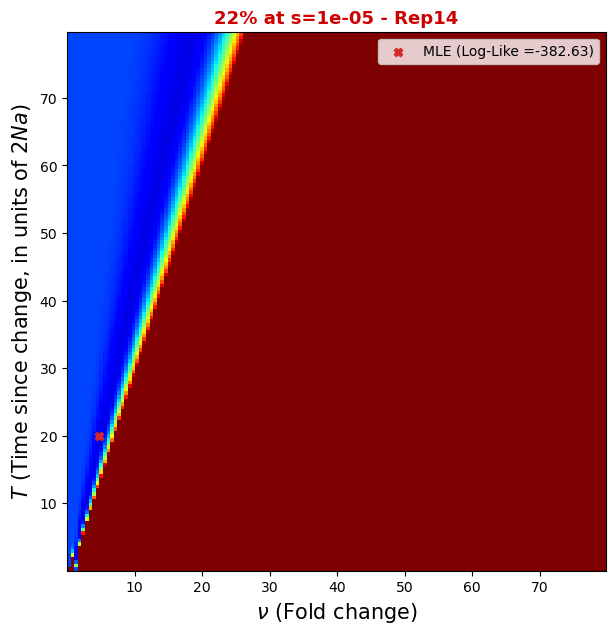

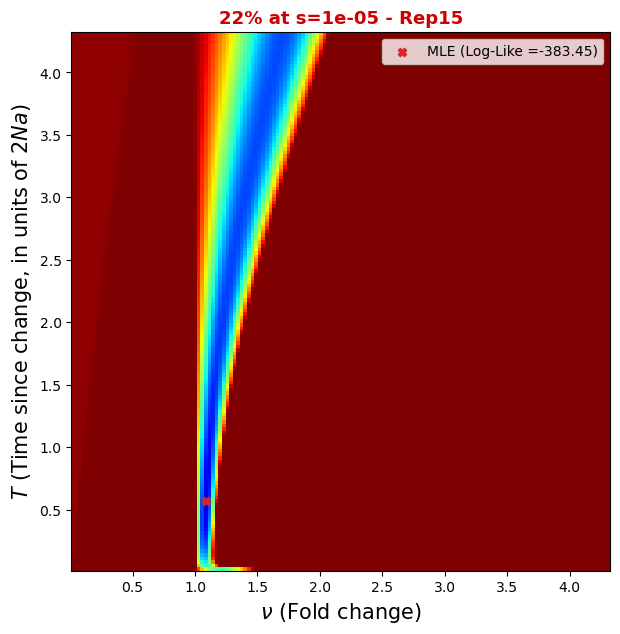

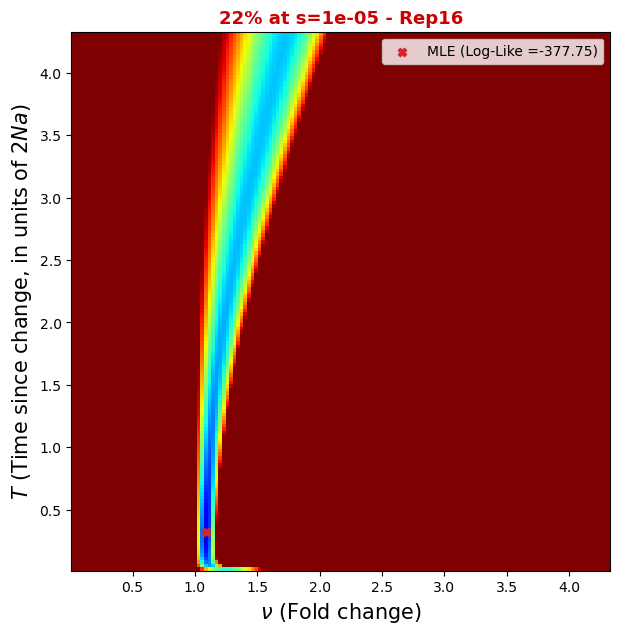

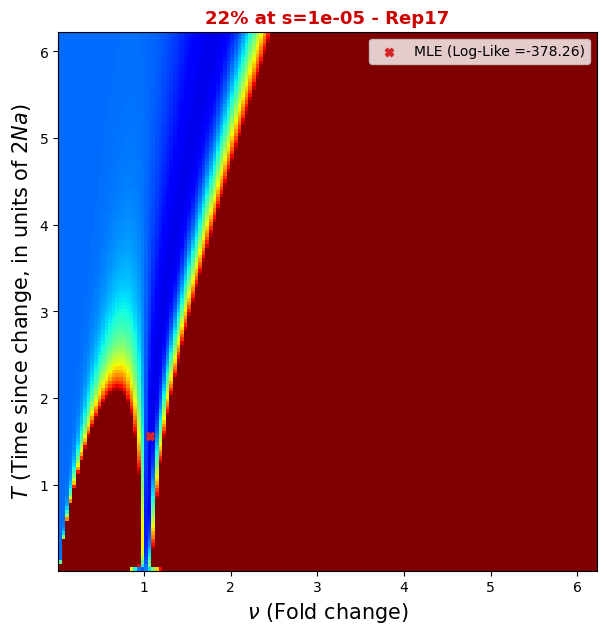

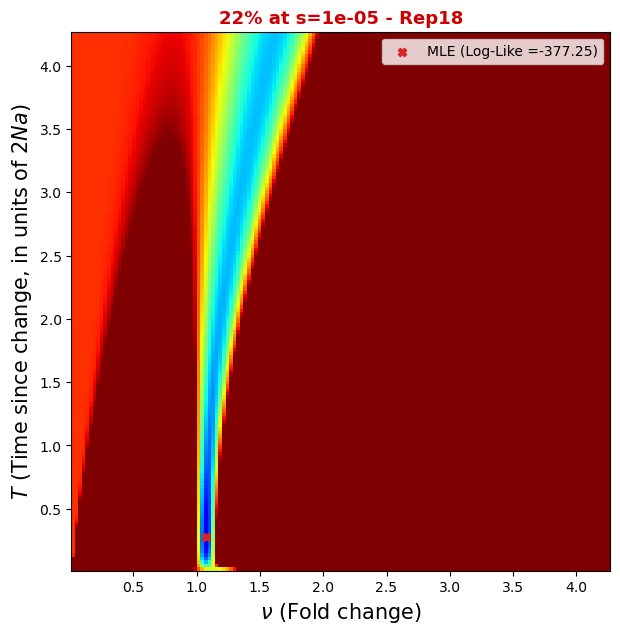

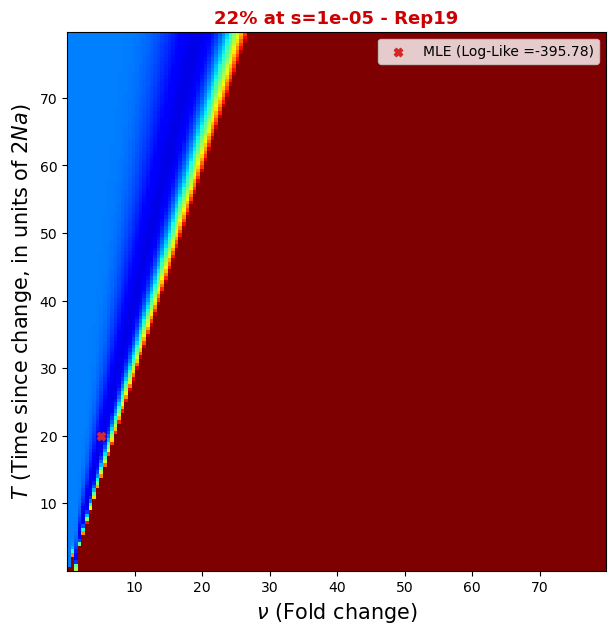

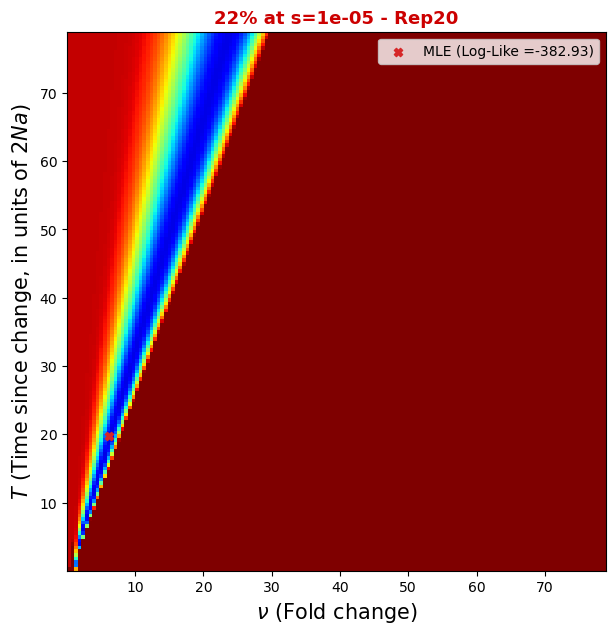

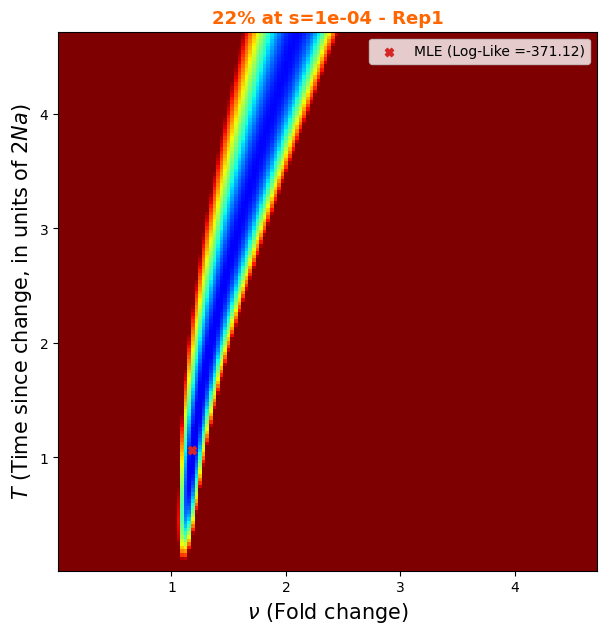

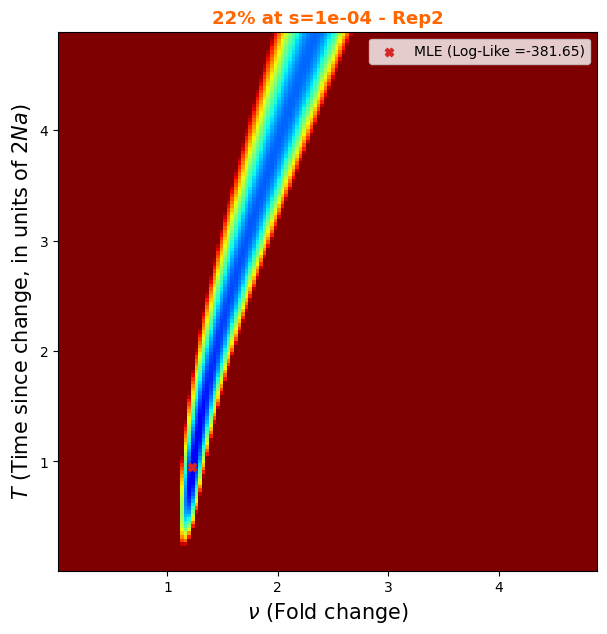

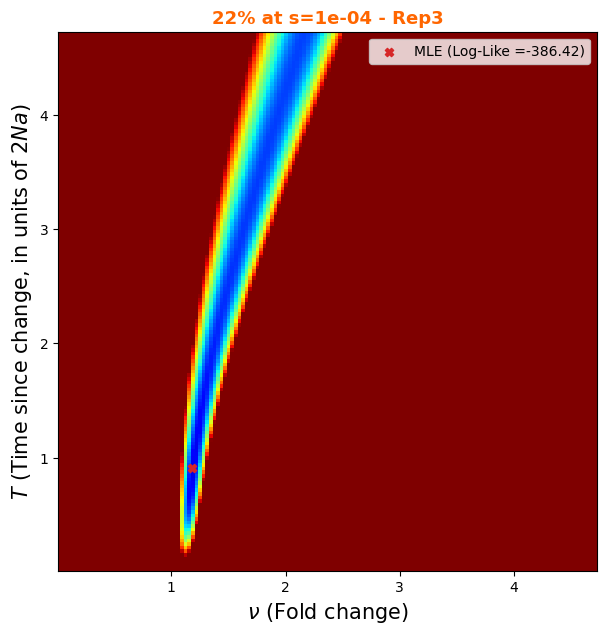

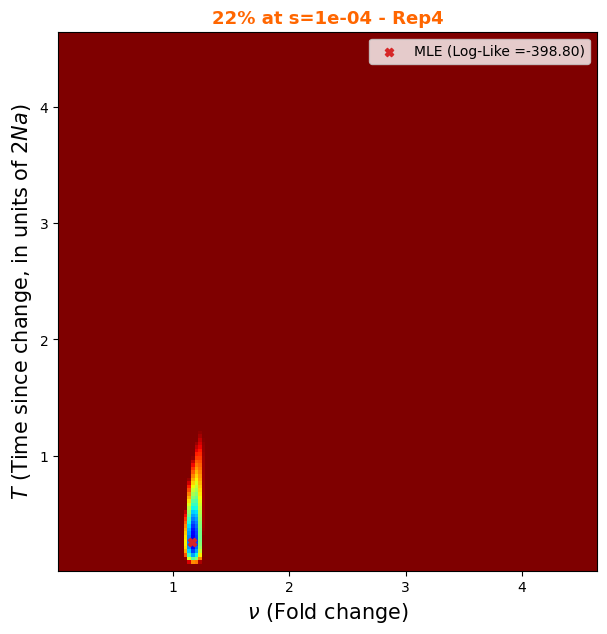

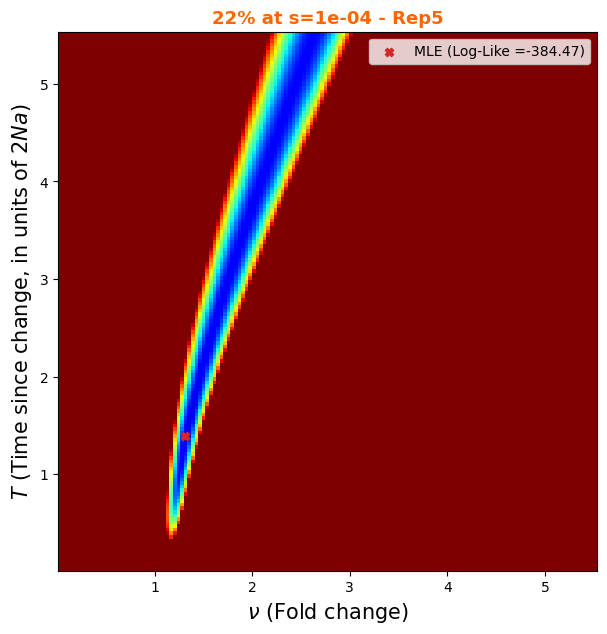

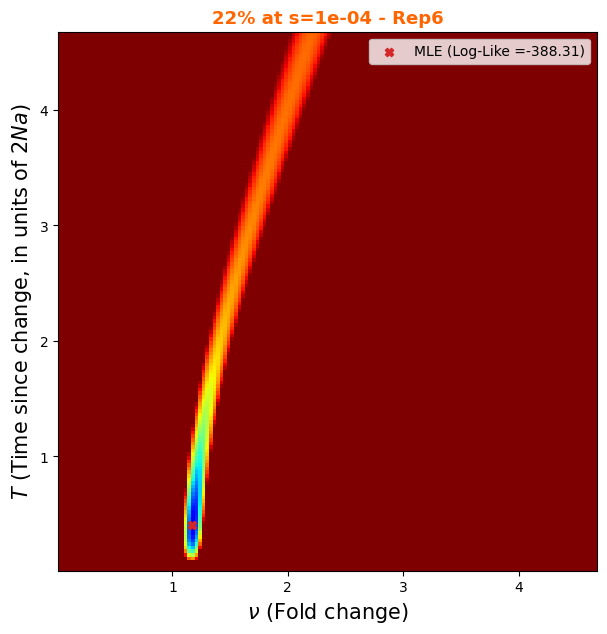

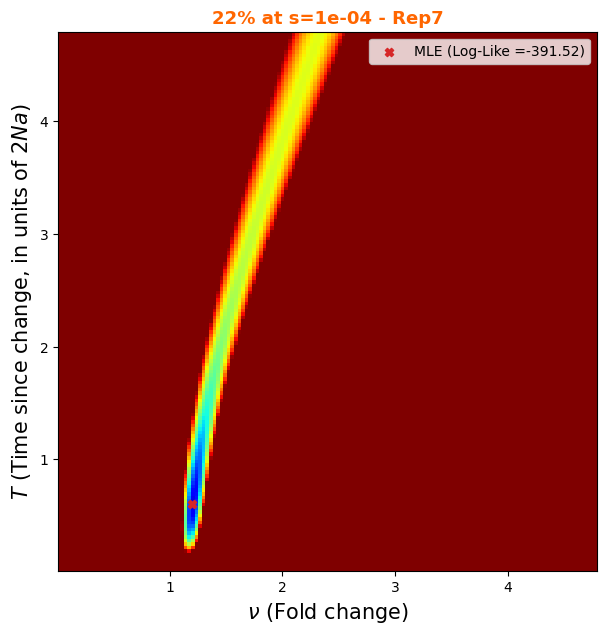

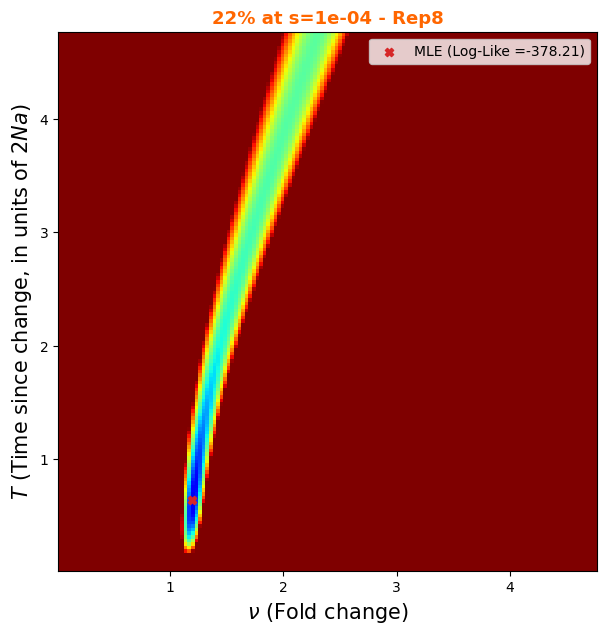

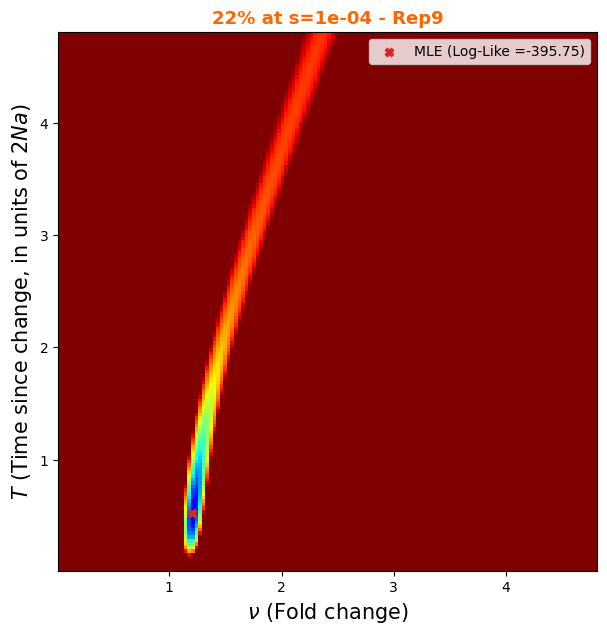

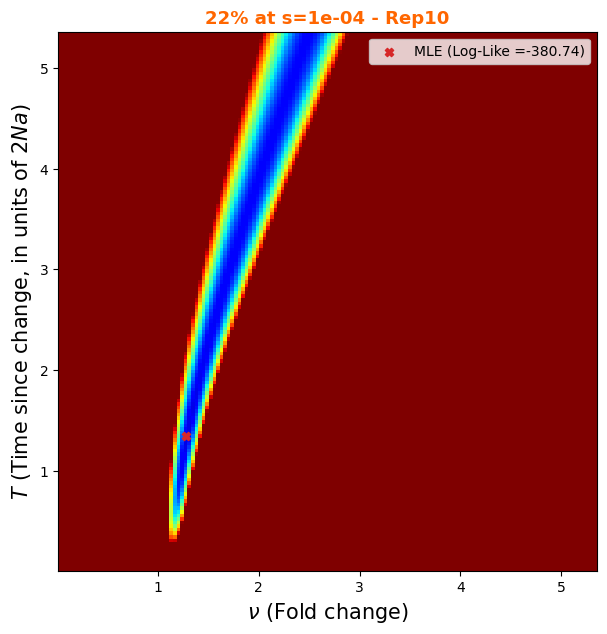

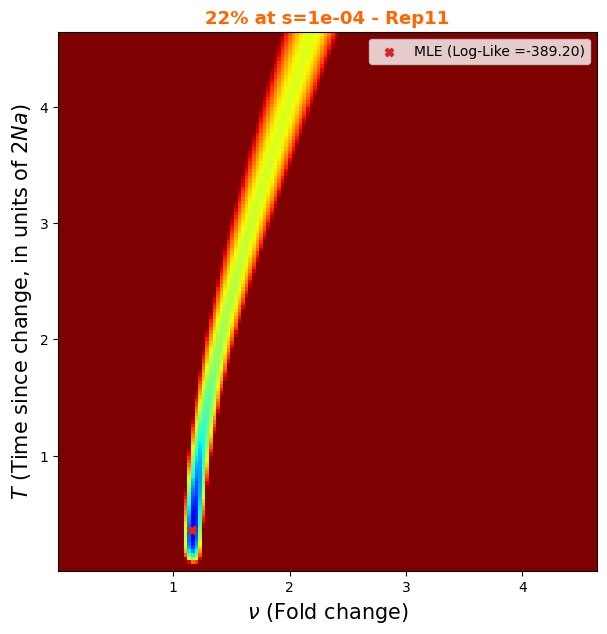

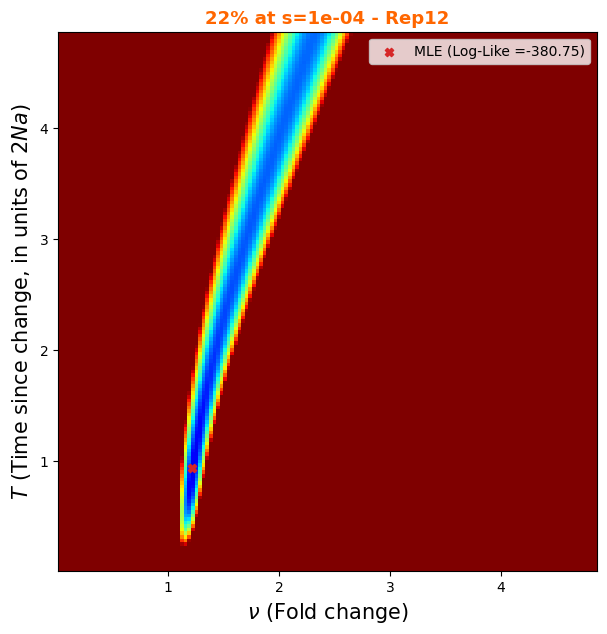

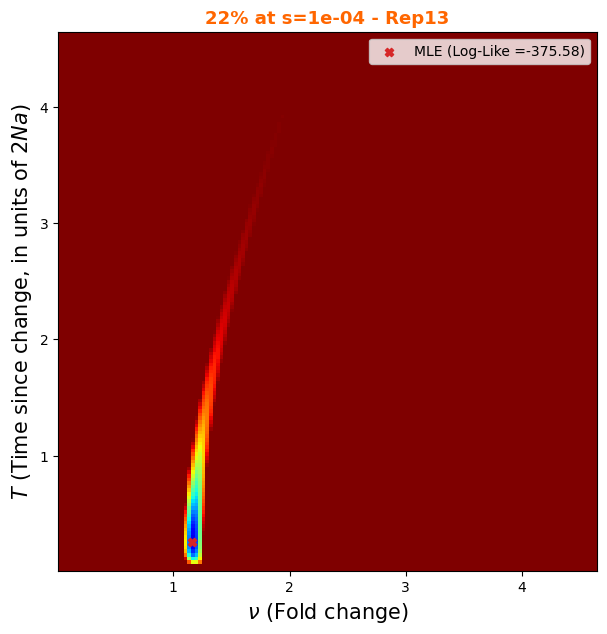

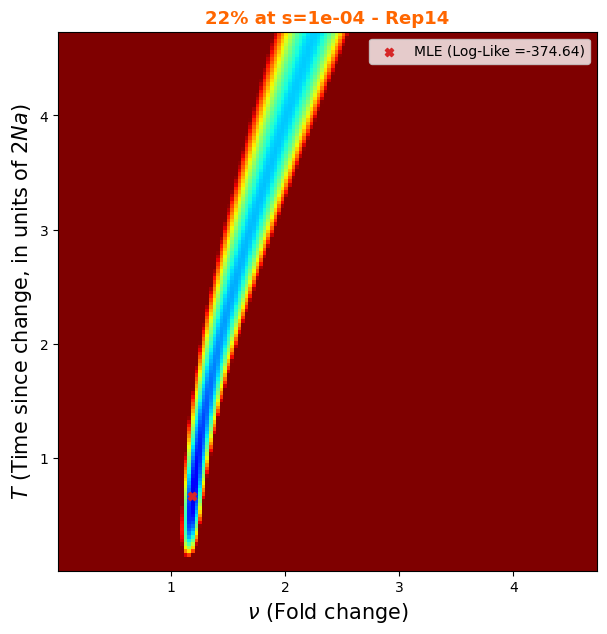

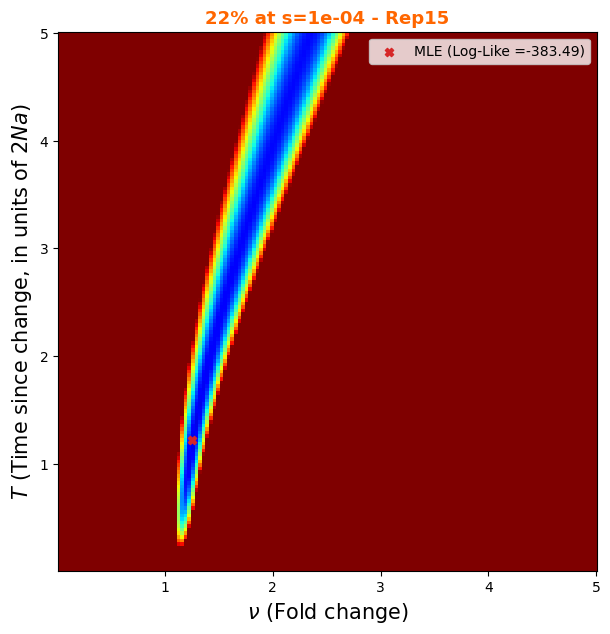

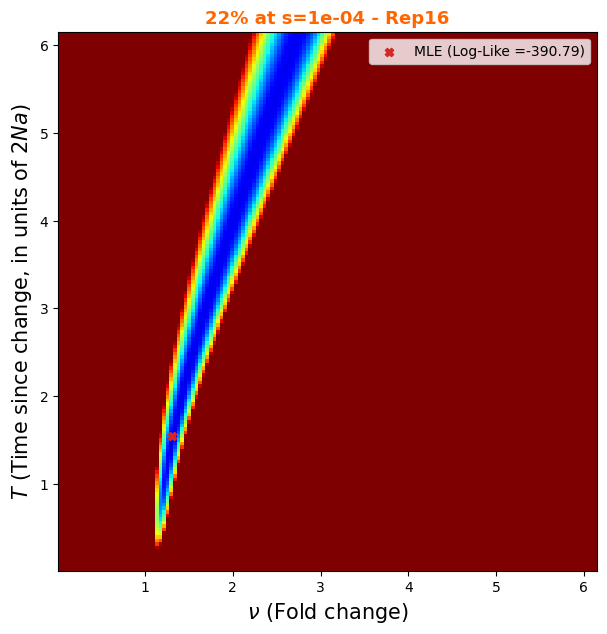

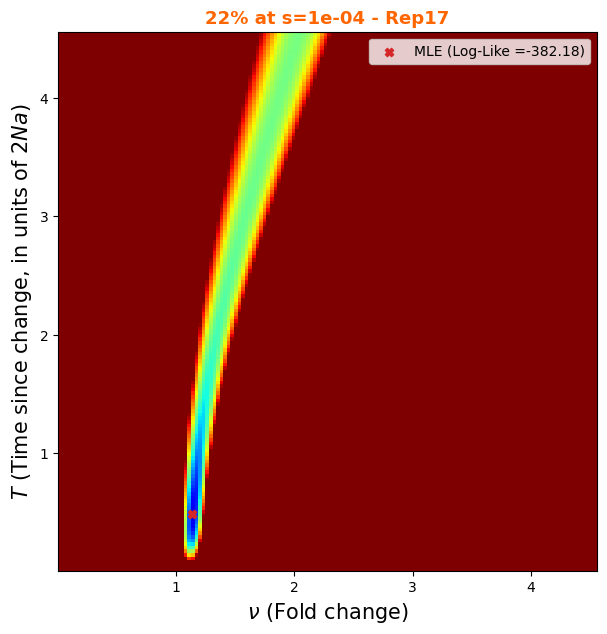

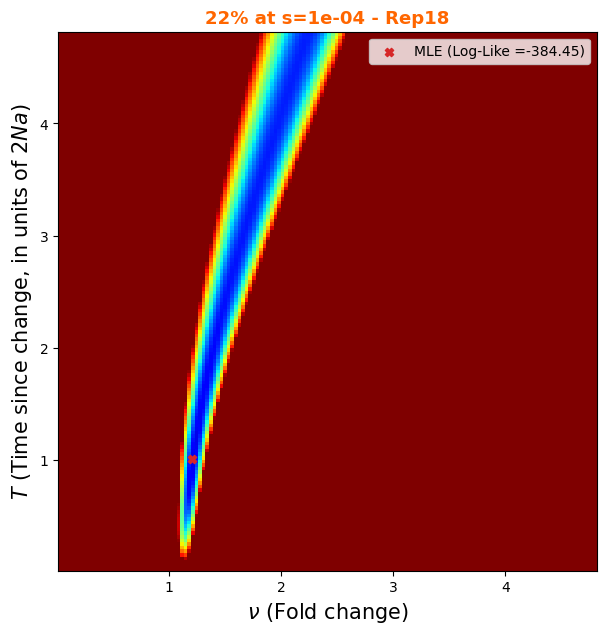

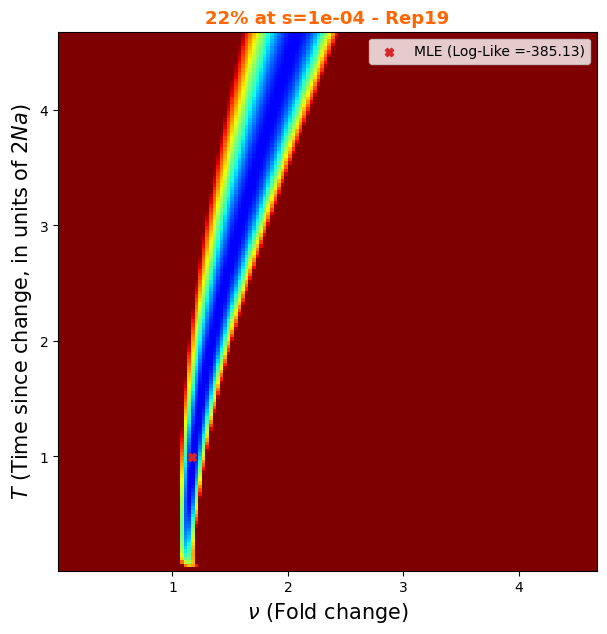

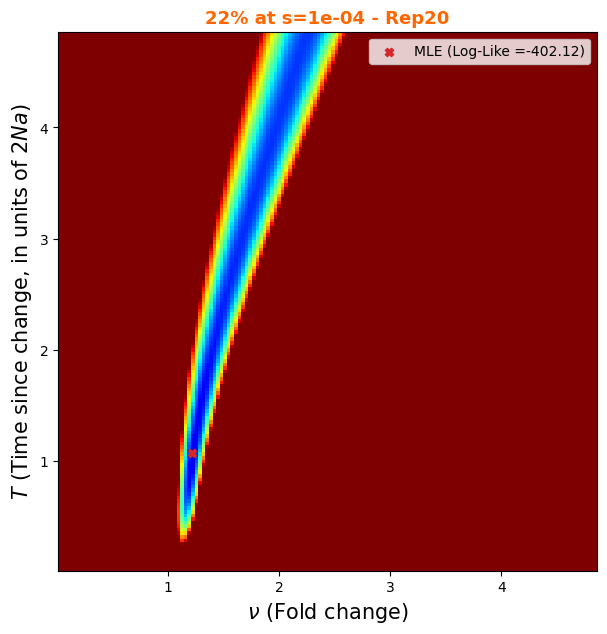

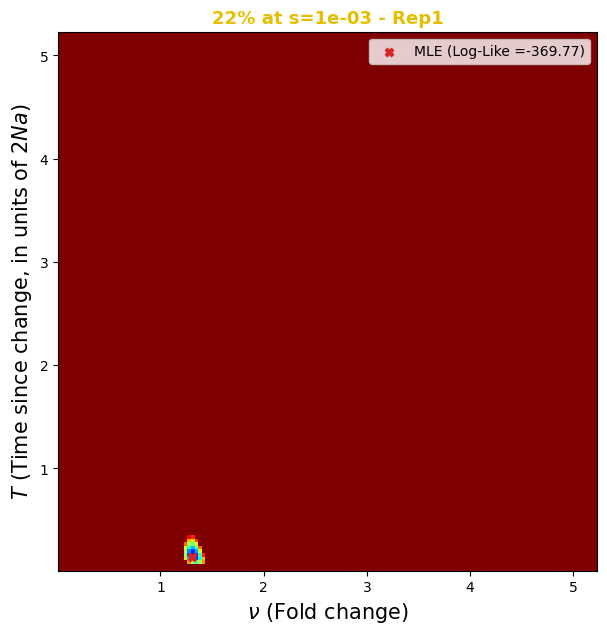

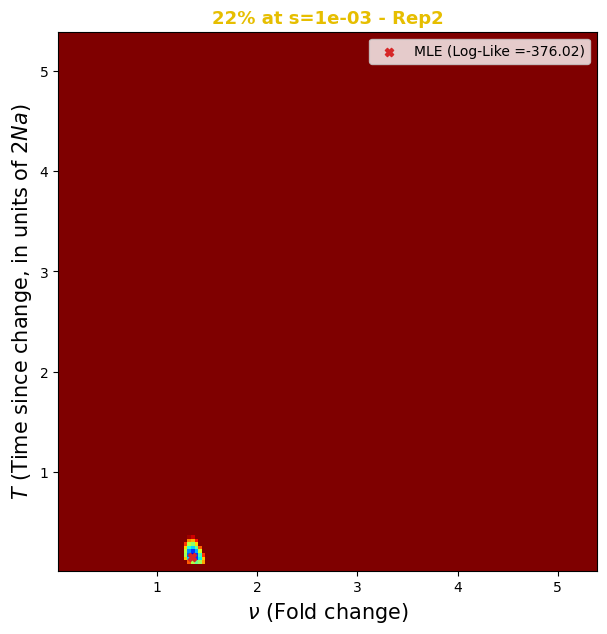

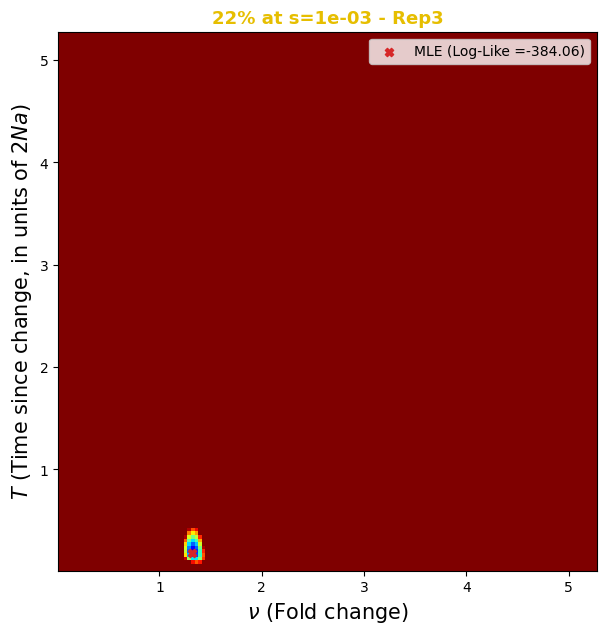

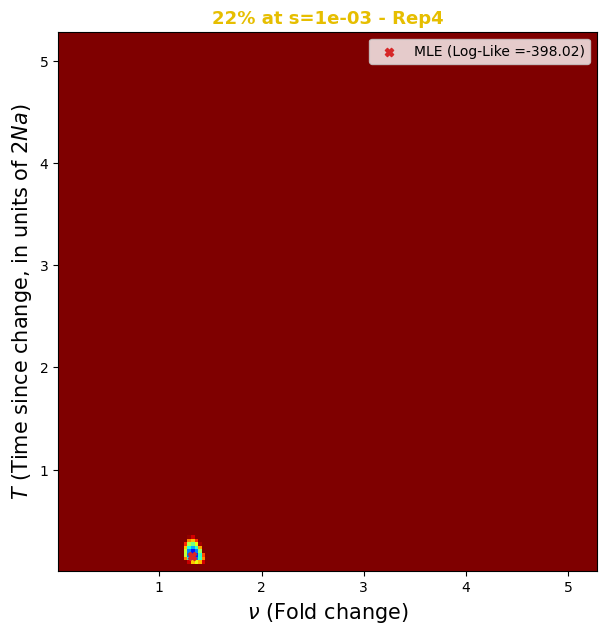

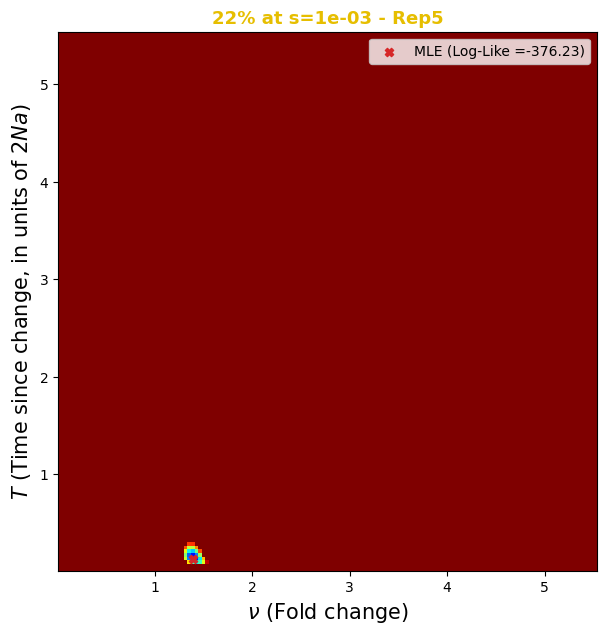

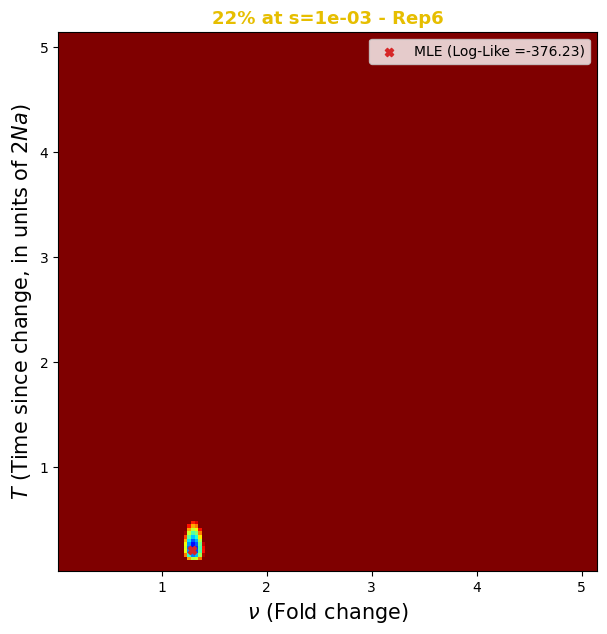

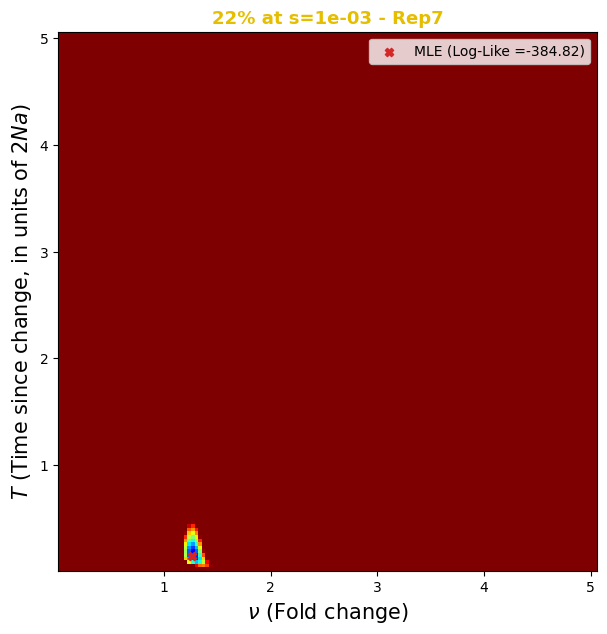

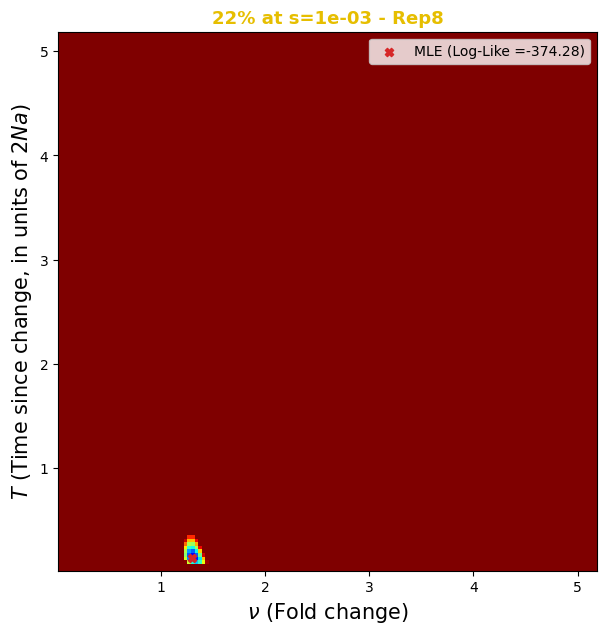

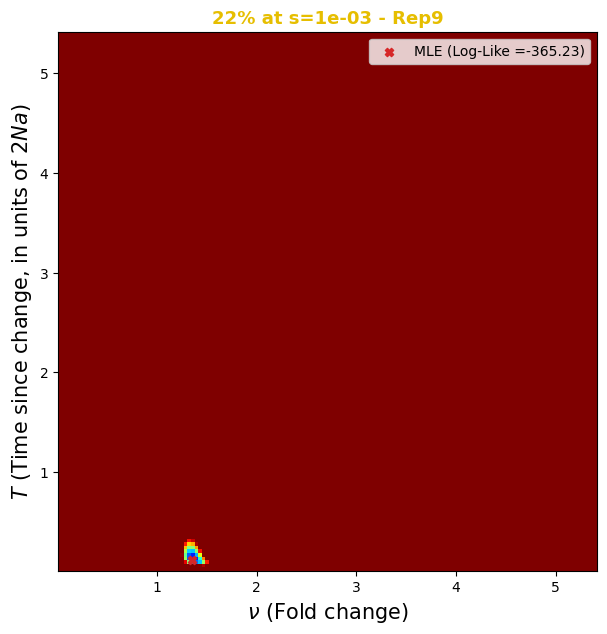

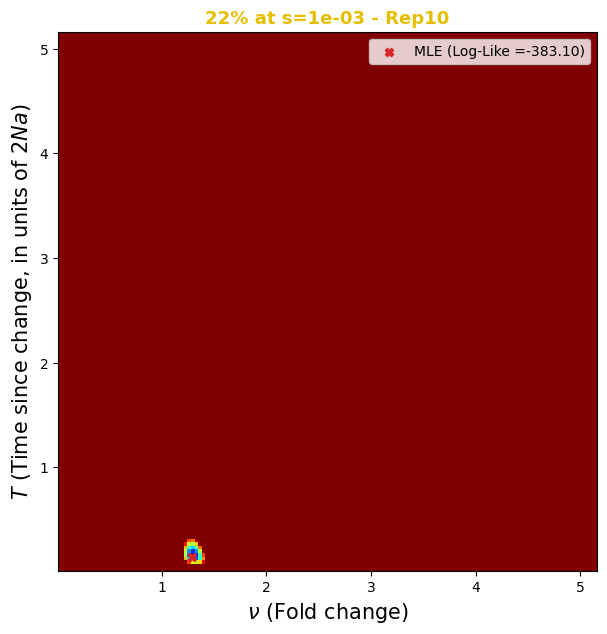

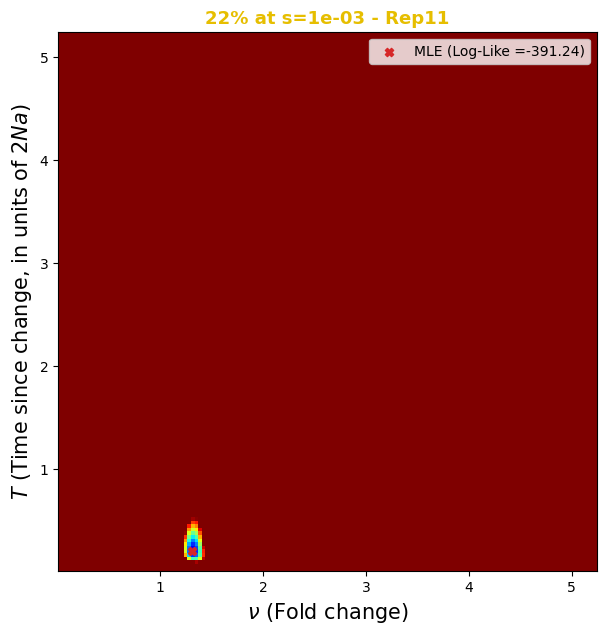

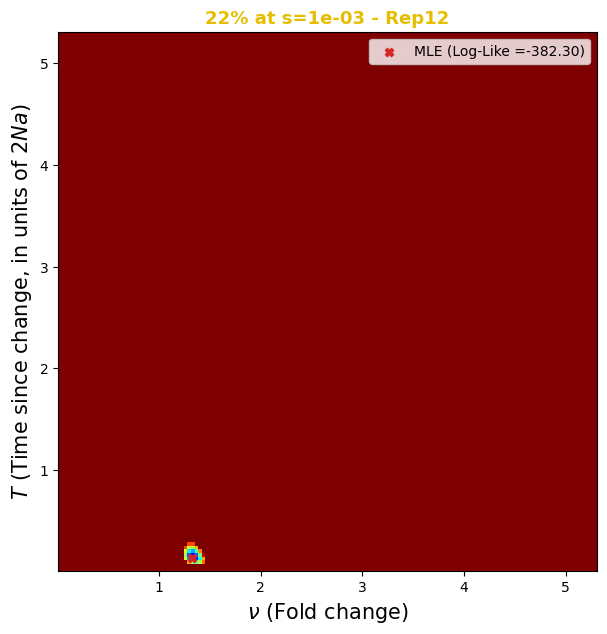

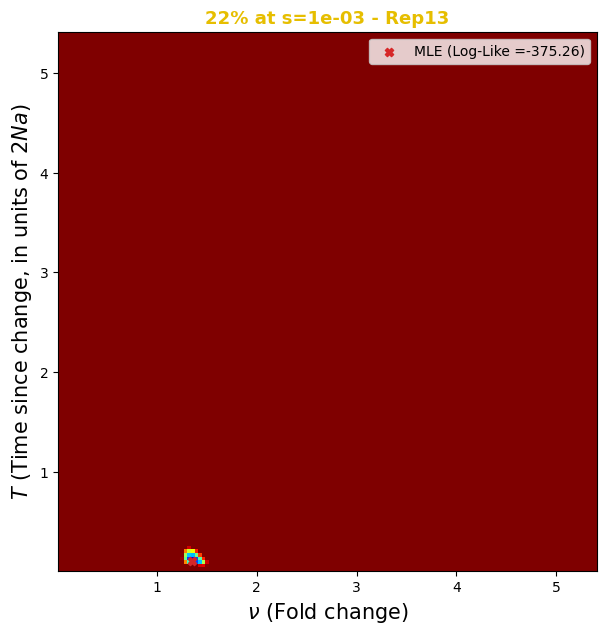

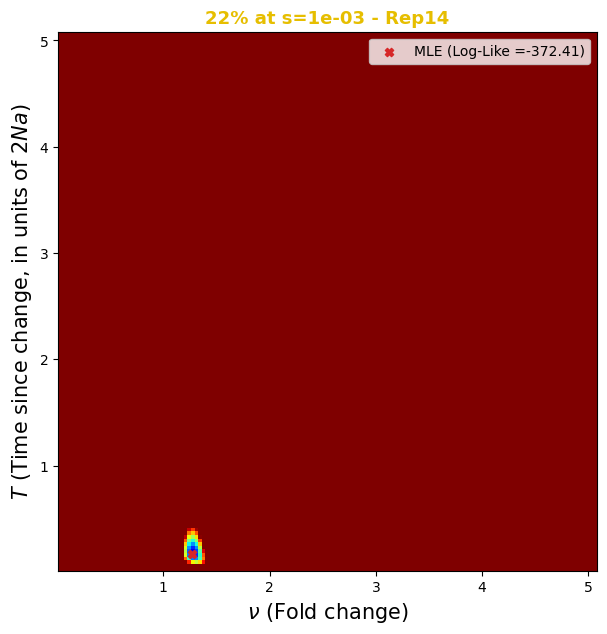

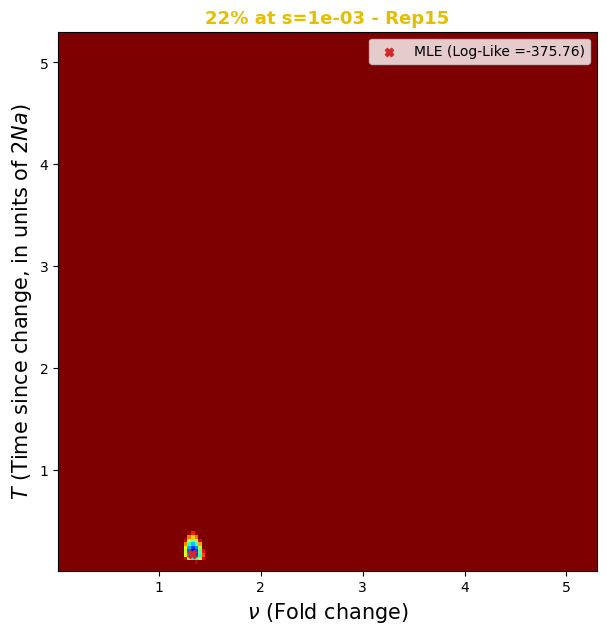

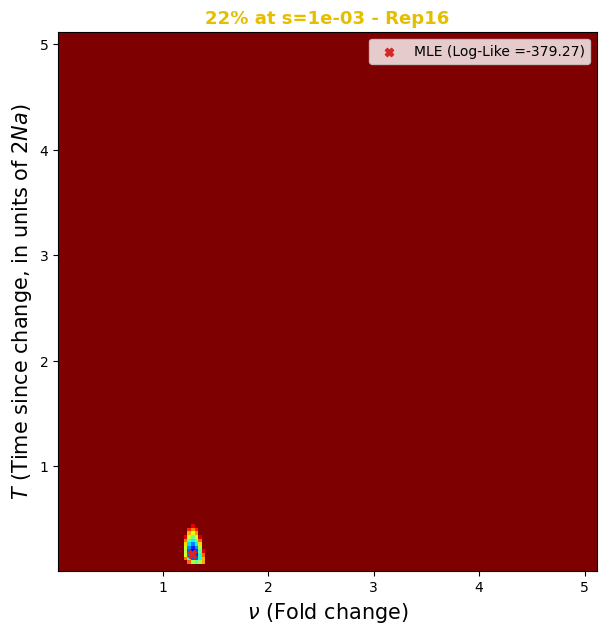

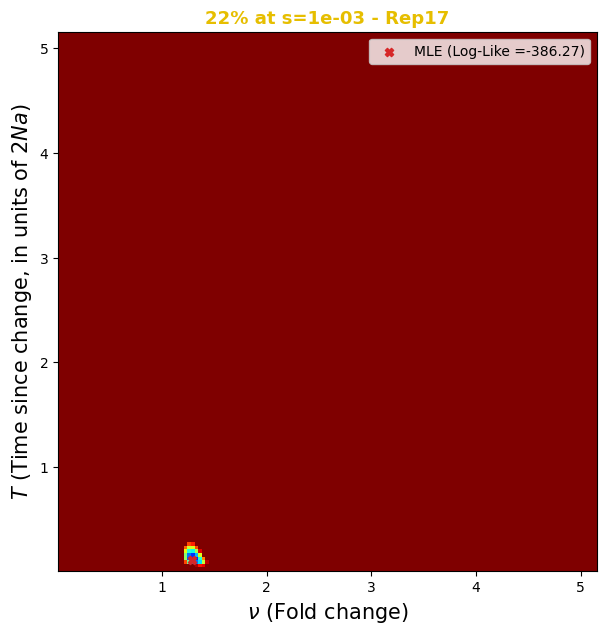

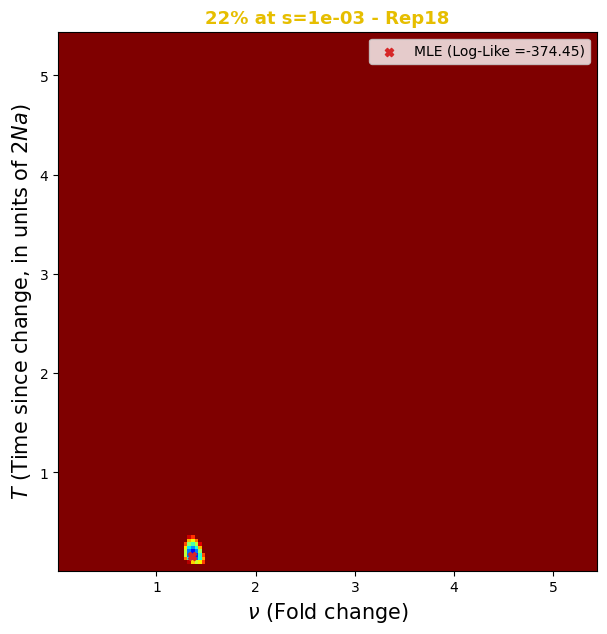

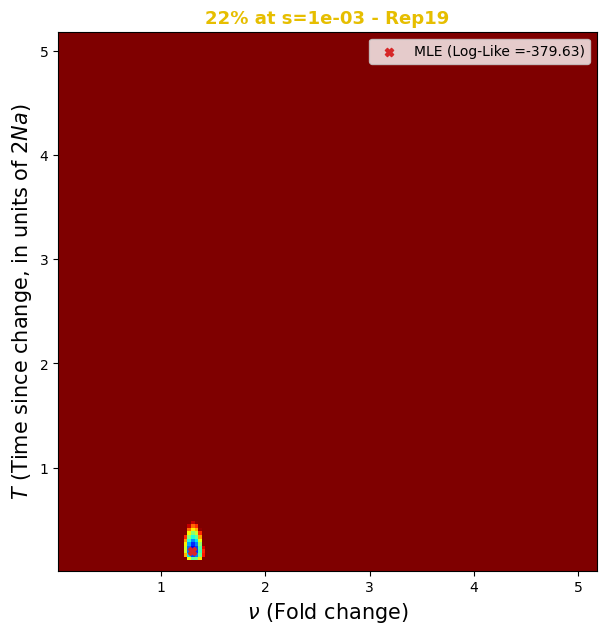

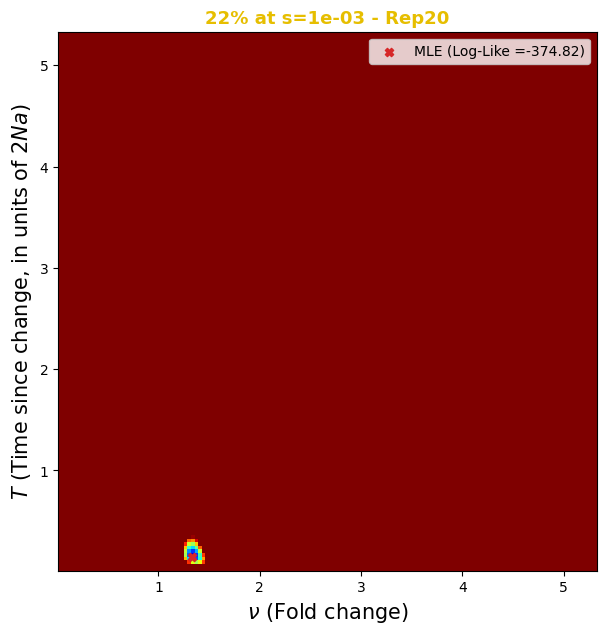

In [11]:
#Plot every single possible surface
for dataid in all_dataids:
    if dataid not in missing_dataids:
        print(f"Plotting {dataid}...")
        fig = plt.figure(figsize=(7, 7))

        # Shared colormap and normalization
        norm = Normalize(vmin=like_min_rescaled, vmax=like_max_rescaled)
        cmap = cm.get_cmap(color_scheme)


        Z_rescaled=loglike_surfaces_rescaled[dataid]
        X_unique = x_values[dataid]
        Y_unique = y_values[dataid]
        input_nu, input_tau = inferred_dem_params[dataid]
        likelihood_model = likelihood_mle[dataid]


        plt.imshow(Z_rescaled ,cmap=cmap, norm=norm, origin='lower', aspect='equal',\
                extent = [min(X_unique), max(X_unique), min(Y_unique), max(Y_unique)])

        #Add the true value
        plt.scatter(input_nu, input_tau, color='C3', marker='X', s=35, label=f"MLE (Log-Like ={likelihood_model:.2f})")
        plt.legend()

        #Create the title 
        condition = map_dataid_condition[dataid]
        rep_id = dataid.split('_')[-1]
        plt.title(f"{title_conditions[condition]} - {rep_id}", fontsize=13, color=color_conditions[condition], weight='bold')

        plt.xlabel(r"$\it{\nu}$ (Fold change)", fontsize=15)
        plt.ylabel(r"$\it{T}$ (Time since change, in units of $\it{2Na}$)", fontsize=15)


        # Create a ScalarMappable for the colorbar
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
        cb = fig.colorbar(mappable, ax=axes, orientation='vertical', fraction=0.04, pad=0.02)
        cb.set_label('Log-Likelihood units from MLE', fontsize=12)

        plt.savefig(f'LogLikeSurface_{dataid}.png', dpi=300, bbox_inches='tight')


#plt.savefig('SuppFig16B_LogLikeSurfaces.png', dpi=300, bbox_inches='tight')

## Human population history

In [21]:
#Plot the surfaces for the human population history cases
#Load all surface data
plotting_replicates={'African_NoSynSel_Extended':np.arange(1,11), 
                    'African_SynSel_Extended':np.arange(1,11)}

color_conditions={'SLiM_True_DFE':'#99b3ff', 'African_NoSynSel_Extended':'#9bc238', 'European_NoSynSel':'#267326', 'African_SynSel_Extended':'#cc0000',
                  'European_SynSel': '#ff6600'}
title_conditions={'SLiM_True_DFE':'True model', 'African_NoSynSel_Extended':'Africa, s=0', 'European_NoSynSel':'Europe, s=0', 
                  'African_SynSel_Extended':'$Africa, s=DFE_{Syn}$','European_SynSel': '$Europe, s=DFE_{Syn}$'}

In [22]:
#Dic with the shape {'condition_dadioutput':[rep_number, rep_number, ...]}
#plotting_replicates={'Zero':[4, 1], 'E5':[5, 8], 'E4':[3, 9], 'E5_Partial':[12, 7], 'E4_Partial':[2, 3], 'E3_Partial':[1, 6]}

#All the loglike surfaces and other parameters. Data identified as "condition_dadioutput_Rep{rep_number}"
inferred_dem_params={}
likelihood_mle={}
loglike_surfaces={}
loglike_surfaces_rescaled={}
x_values={}
y_values={}
map_dataid_condition={}

all_dataids=[]
missing_dataids=[]

for condition in plotting_replicates.keys():
    for rep in plotting_replicates[condition]:
        dataid=f"{condition}_Rep{rep}"
        print(f"Processing {dataid}...")
        map_dataid_condition[dataid]=condition
        all_dataids.append(dataid)

        #Get the originally inferred demographic parameters
        input_file_demography=f"/u/project/klohmuel/amzurita/Synonimous_Selection_Simulations/HumanSimulations/DadiFits_OutputFiles/{condition}_Replicate{rep}_two_epoch_demography.txt"
      
        with open(input_file_demography, 'r') as file:
            for line in file:
                if 'Maximum multinomial log composite likelihood: ' in line:
                    parsed_params=line.strip().strip('.').split(': ')[1]
                    print(parsed_params)
                    likelihood_model=float(parsed_params)
                    likelihood_mle[dataid]=likelihood_model
                elif 'Best fit parameters: ' in line:
                    parsed_params=line.strip().strip('.').split(': ')[1]
                    parsed_params=parsed_params.strip('[').strip(']')
                    demog_params=[float(x.strip(',')) for x in parsed_params.split()]
                    print(demog_params)
                    inferred_dem_params[dataid]=demog_params


        #Load the loglike surface
        try:
            df=pd.read_csv(f"/u/project/klohmuel/amzurita/Synonimous_Selection_Simulations/HumanSimulations/DadiFits_OutputFiles/likelihood_surface_{condition}_Replicate{rep}.csv", index_col=0)
        except FileNotFoundError:
            print(f"File not found for {dataid}. Skipping...")
            missing_dataids.append(dataid)
            continue
        input_nu, input_tau = demog_params

        like_max = abs(likelihood_model)+10
        like_min = abs(likelihood_model)-10    

        #Prepare the data
        Z = df.pivot_table(index='X', columns='Y', values='Z').T.values
        X_unique = np.sort(df.X.unique())
        Y_unique = np.sort(df.Y.unique())
        X, Y = np.meshgrid(X_unique, Y_unique)

        #Store the x and y values for plotting
        x_values[dataid] = X_unique
        y_values[dataid] = Y_unique

        #Plotting with a log scale color gradient
        Z = np.abs(Z)  # Ensure all values are positive, for log scaling.

        #Rescale with respect to the maximum likelihood
        Z_rescaled = Z - abs(likelihood_model)

        loglike_surfaces[dataid] = Z
        loglike_surfaces_rescaled[dataid] = Z_rescaled

Processing African_NoSynSel_Extended_Rep1...
[2.37249862, 0.570655]
-370.96892360126867
Processing African_NoSynSel_Extended_Rep2...
[2.28490499, 0.55067759]
-365.1910969564537
Processing African_NoSynSel_Extended_Rep3...
[2.14378454, 0.47463581]
-381.560282299468
Processing African_NoSynSel_Extended_Rep4...
[2.24556824, 0.48579962]
-363.9166169242576
Processing African_NoSynSel_Extended_Rep5...
[2.23492411, 0.53503058]
-374.827486145848
Processing African_NoSynSel_Extended_Rep6...
[2.19636831, 0.51341546]
-373.3645579323662
Processing African_NoSynSel_Extended_Rep7...
[2.27194439, 0.62060812]
-375.20611028486013
Processing African_NoSynSel_Extended_Rep8...
[2.25824198, 0.54581509]
-375.9254302568755
Processing African_NoSynSel_Extended_Rep9...
[2.31354314, 0.53418199]
-364.2810662799466
Processing African_NoSynSel_Extended_Rep10...
[2.19528336, 0.51940386]
-370.35750510884156
Processing African_SynSel_Extended_Rep1...
[3.4104173, 0.63064991]
-353.5522631040884
Processing African_SynSe

Plotting African_NoSynSel_Extended_Rep1...
Plotting African_NoSynSel_Extended_Rep2...
Plotting African_NoSynSel_Extended_Rep3...
Plotting African_NoSynSel_Extended_Rep4...
Plotting African_NoSynSel_Extended_Rep5...
Plotting African_NoSynSel_Extended_Rep6...
Plotting African_NoSynSel_Extended_Rep7...
Plotting African_NoSynSel_Extended_Rep8...
Plotting African_NoSynSel_Extended_Rep9...
Plotting African_NoSynSel_Extended_Rep10...
Plotting African_SynSel_Extended_Rep1...
Plotting African_SynSel_Extended_Rep2...
Plotting African_SynSel_Extended_Rep3...
Plotting African_SynSel_Extended_Rep4...
Plotting African_SynSel_Extended_Rep5...
Plotting African_SynSel_Extended_Rep6...
Plotting African_SynSel_Extended_Rep7...
Plotting African_SynSel_Extended_Rep8...
Plotting African_SynSel_Extended_Rep9...
Plotting African_SynSel_Extended_Rep10...


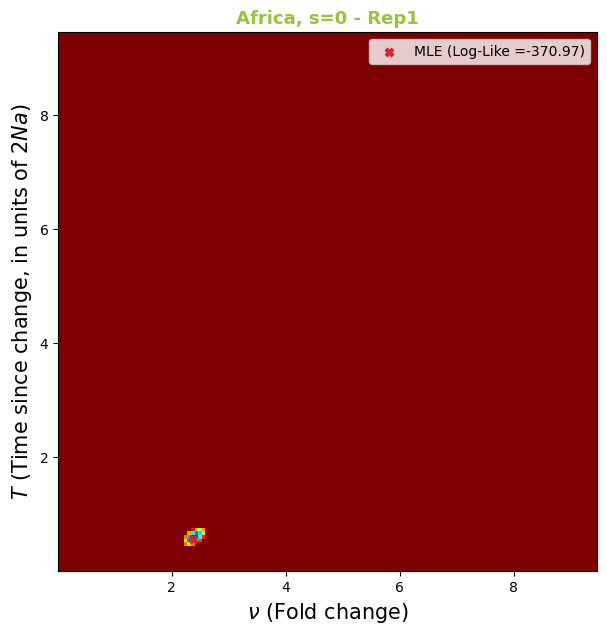

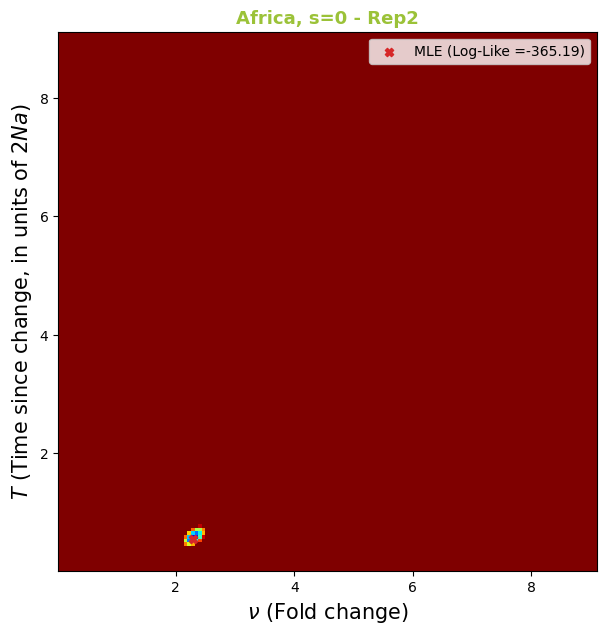

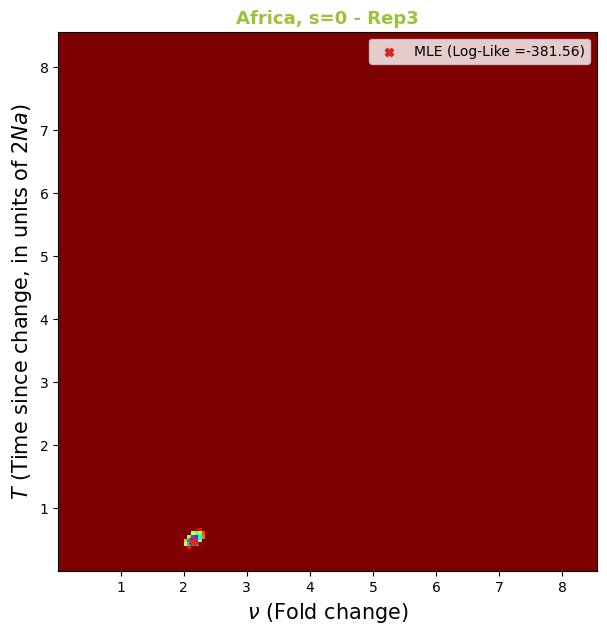

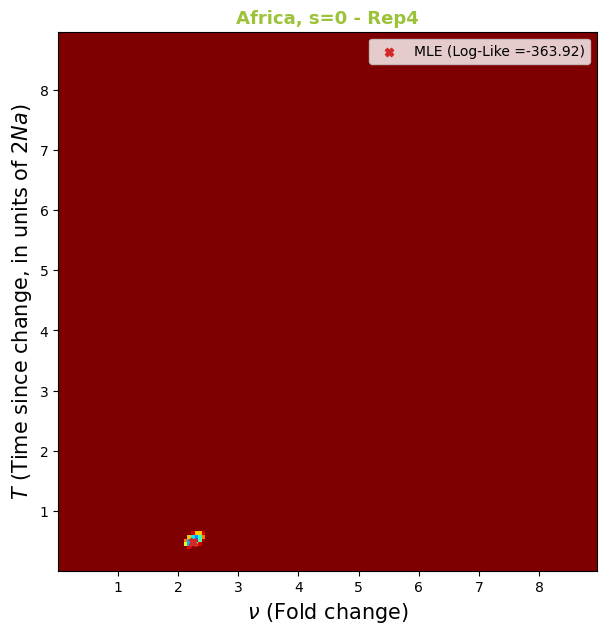

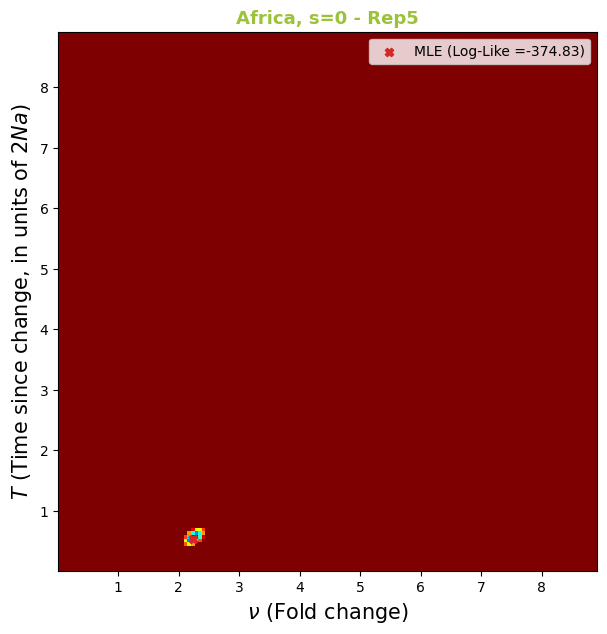

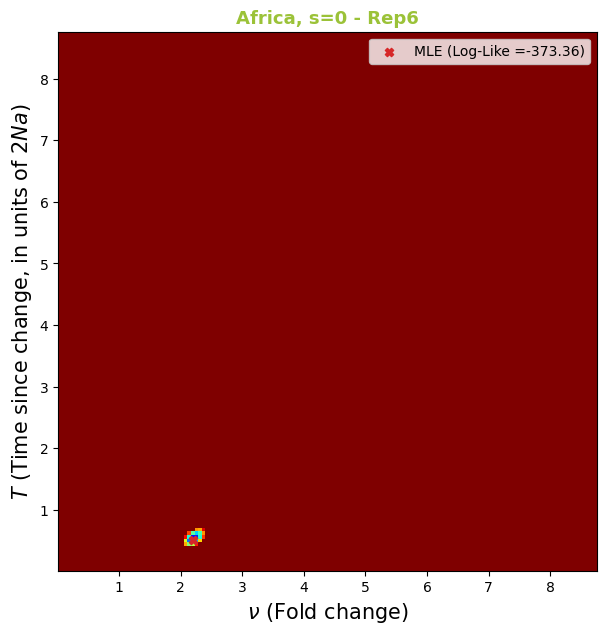

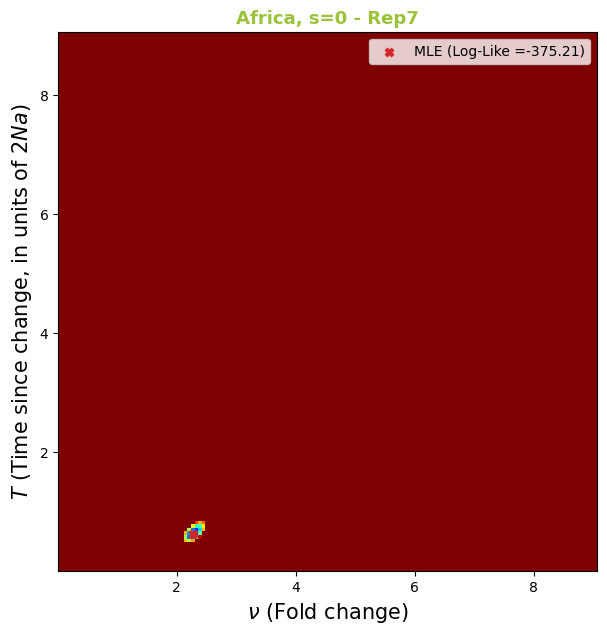

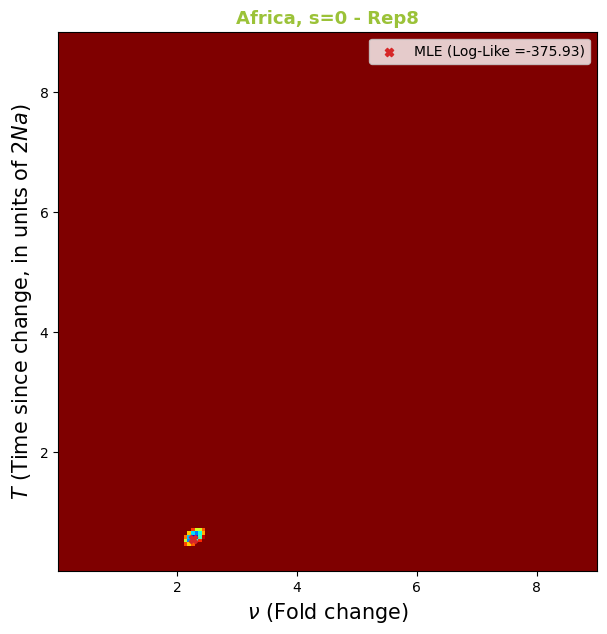

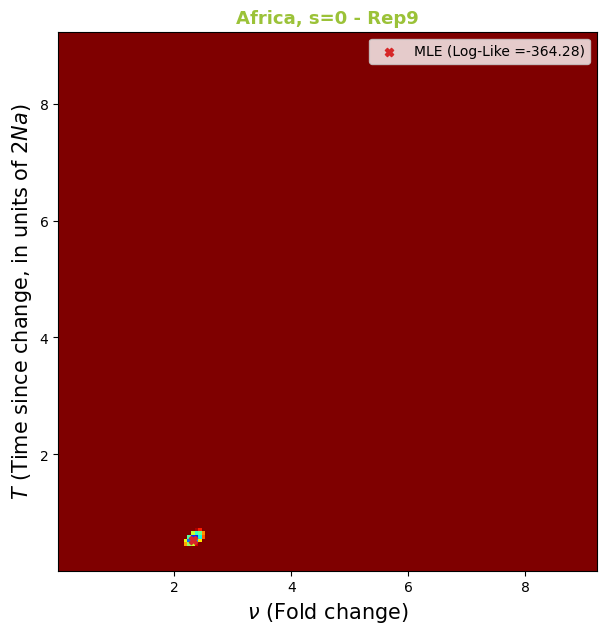

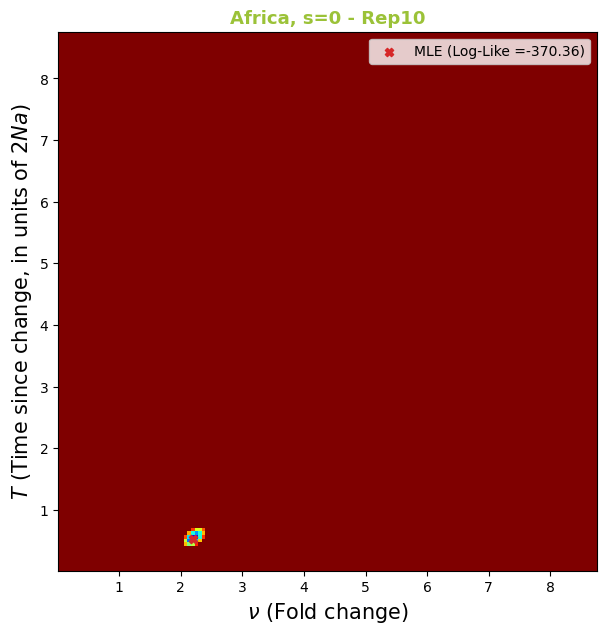

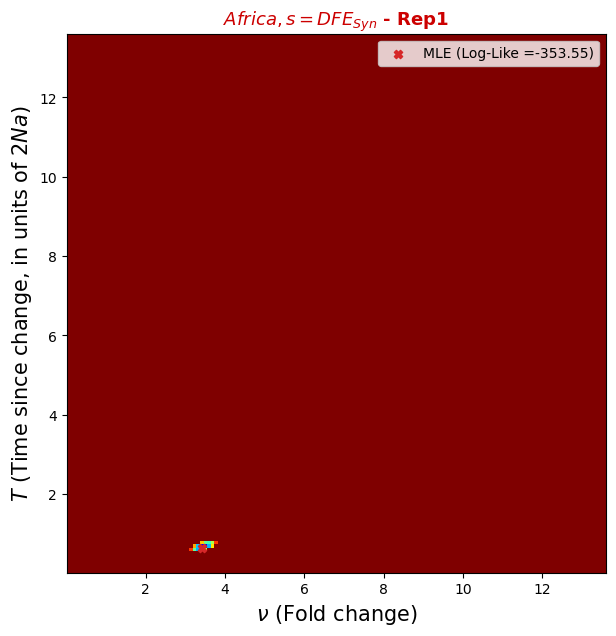

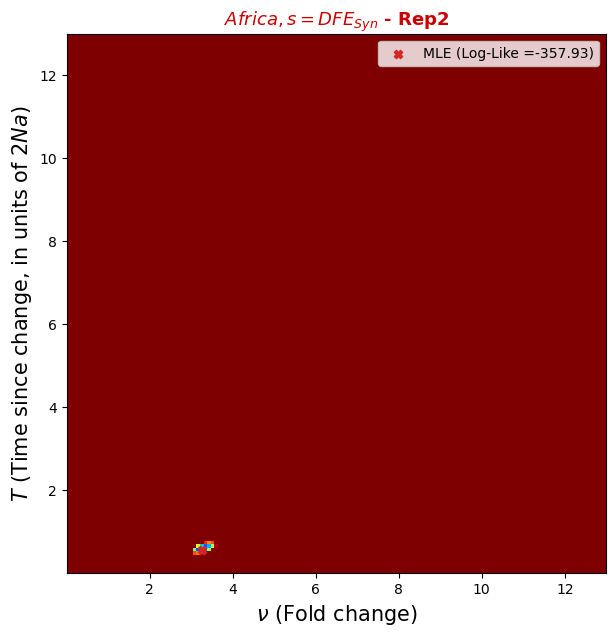

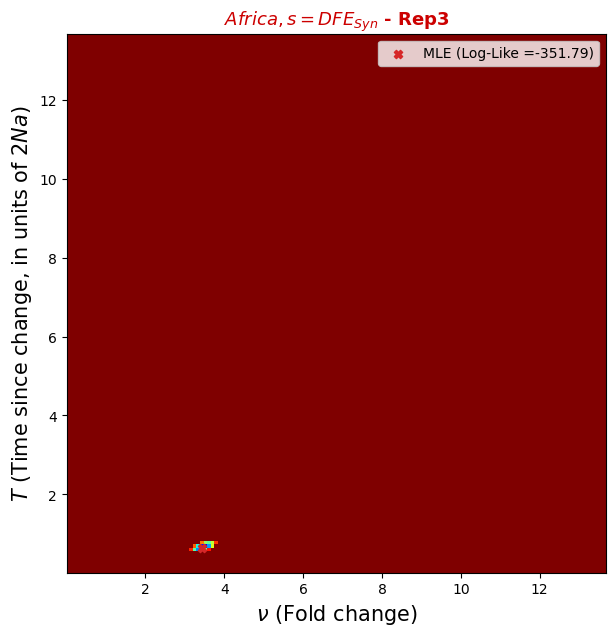

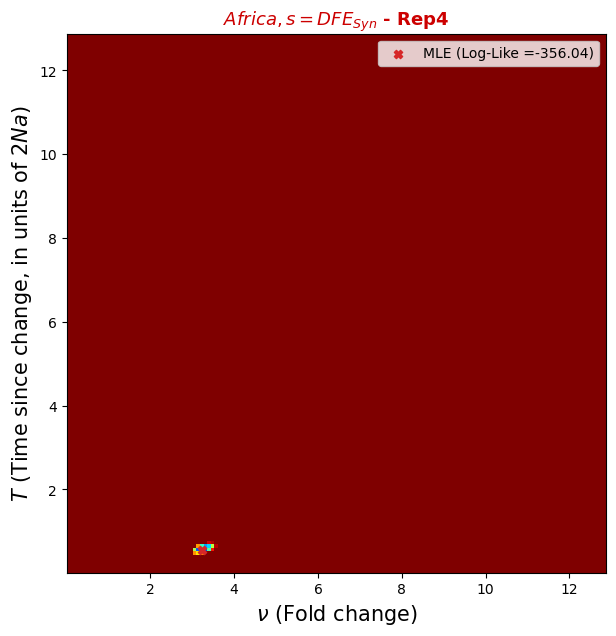

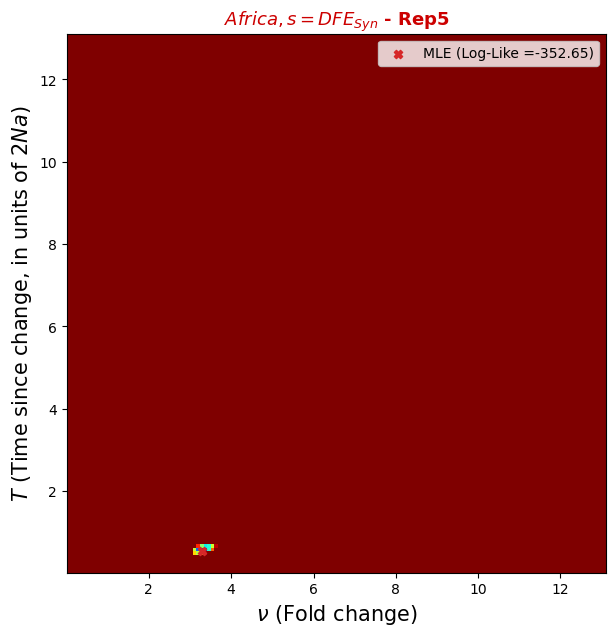

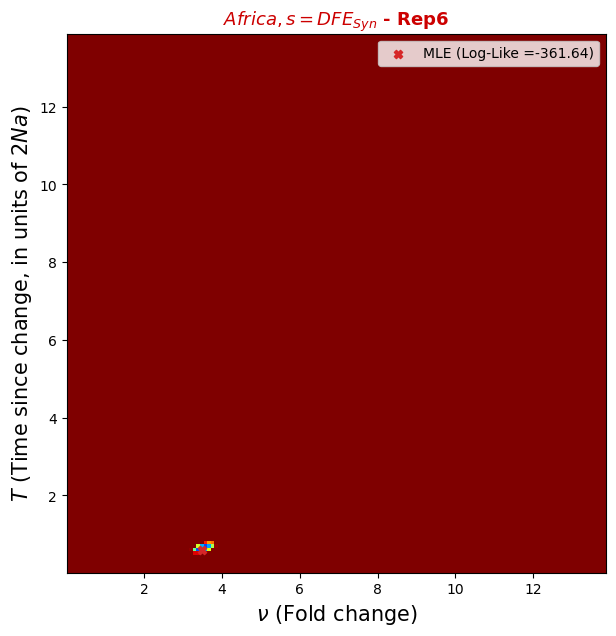

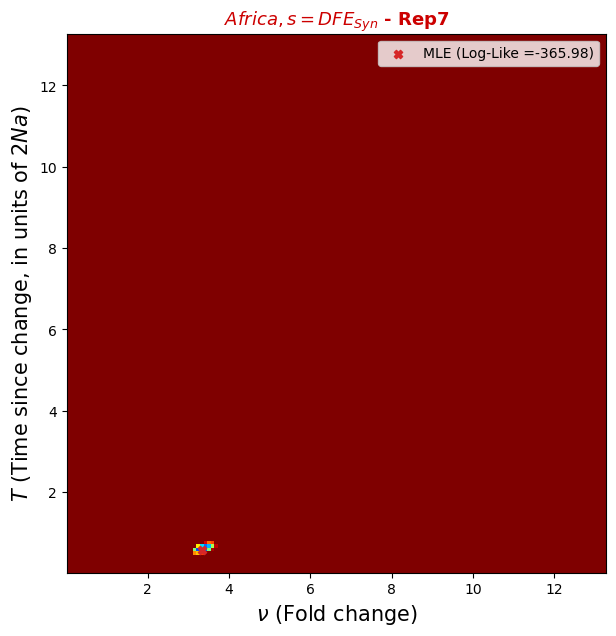

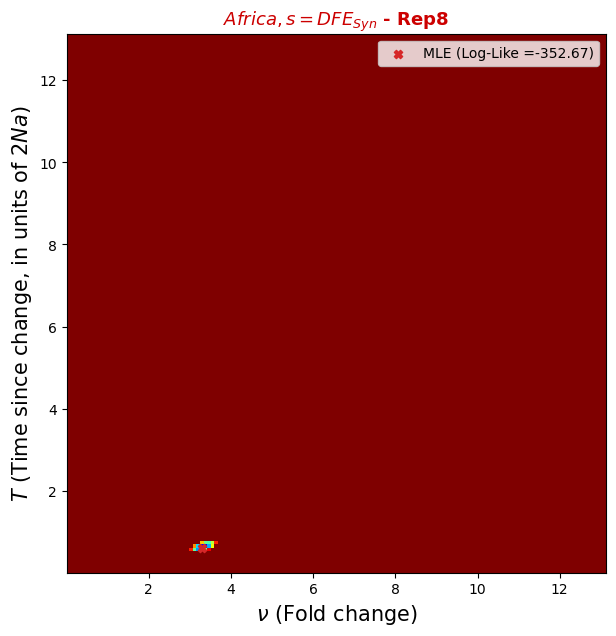

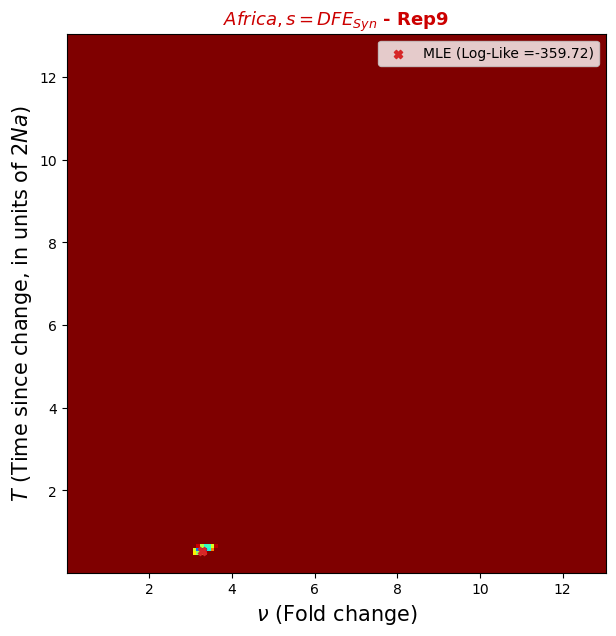

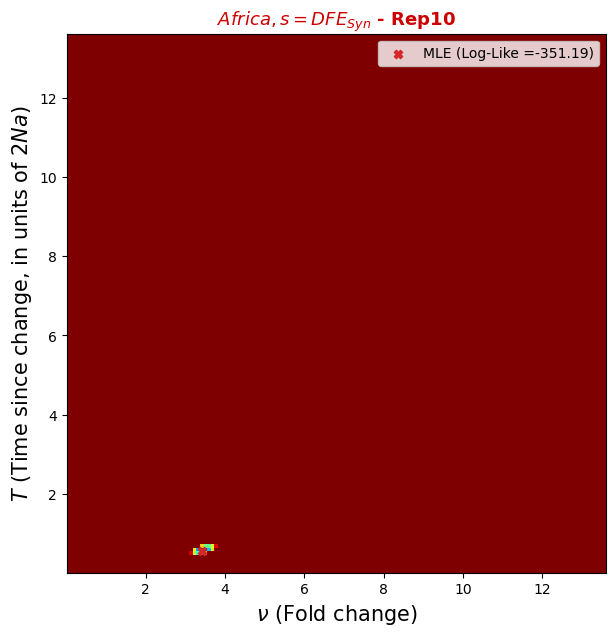

In [23]:
#Plot every single possible surface
for dataid in all_dataids:
    if dataid not in missing_dataids:
        print(f"Plotting {dataid}...")
        fig = plt.figure(figsize=(7, 7))

        # Shared colormap and normalization
        norm = Normalize(vmin=like_min_rescaled, vmax=like_max_rescaled)
        cmap = cm.get_cmap(color_scheme)


        Z_rescaled=loglike_surfaces_rescaled[dataid]
        X_unique = x_values[dataid]
        Y_unique = y_values[dataid]
        input_nu, input_tau = inferred_dem_params[dataid]
        likelihood_model = likelihood_mle[dataid]


        plt.imshow(Z_rescaled ,cmap=cmap, norm=norm, origin='lower', aspect='equal',\
                extent = [min(X_unique), max(X_unique), min(Y_unique), max(Y_unique)])

        #Add the true value
        plt.scatter(input_nu, input_tau, color='C3', marker='X', s=35, label=f"MLE (Log-Like ={likelihood_model:.2f})")
        plt.legend()

        #Create the title 
        condition = map_dataid_condition[dataid]
        rep_id = dataid.split('_')[-1]
        plt.title(f"{title_conditions[condition]} - {rep_id}", fontsize=13, color=color_conditions[condition], weight='bold')

        plt.xlabel(r"$\it{\nu}$ (Fold change)", fontsize=15)
        plt.ylabel(r"$\it{T}$ (Time since change, in units of $\it{2Na}$)", fontsize=15)


        # Create a ScalarMappable for the colorbar
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
        cb = fig.colorbar(mappable, ax=axes, orientation='vertical', fraction=0.04, pad=0.02)
        cb.set_label('Log-Likelihood units from MLE', fontsize=12)

        plt.savefig(f'LogLikeSurface_{dataid}.png', dpi=300, bbox_inches='tight')